        Image Index          Finding Labels  Follow-up #  Patient ID   
0  00000001_000.png            Cardiomegaly            0           1  \
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   
5  00000003_001.png                  Hernia            1           3   
6  00000003_002.png                  Hernia            2           3   
7  00000003_003.png     Hernia|Infiltration            3           3   
8  00000003_004.png                  Hernia            4           3   
9  00000003_005.png                  Hernia            5           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]   
0           58              M            PA                 2682     2749  \
1           58              M            PA          

/var/folders/hq/s7g8cnvs48l0l1mw7y7g241r0000gn/T/ipykernel_1331/1273828670.py:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  labels = torch.tensor(labels)


Skipping corrupted file: /Users/rau/Library/Mobile Documents/com~apple~CloudDocs/data/images_011/images/00028145_003.png
Total corrupted images: 1
Skipping corrupted file: /Users/rau/Library/Mobile Documents/com~apple~CloudDocs/data/images_011/images/00028173_001.png
Total corrupted images: 2
Skipping corrupted file: /Users/rau/Library/Mobile Documents/com~apple~CloudDocs/data/images_011/images/00028163_000.png
Total corrupted images: 3
Skipping corrupted file: /Users/rau/Library/Mobile Documents/com~apple~CloudDocs/data/images_011/images/00028173_000.png
Total corrupted images: 4
Skipping corrupted file: /Users/rau/Library/Mobile Documents/com~apple~CloudDocs/data/images_011/images/00028145_002.png
Total corrupted images: 5
Skipping corrupted file: /Users/rau/Library/Mobile Documents/com~apple~CloudDocs/data/images_011/images/00028145_000.png
Total corrupted images: 6
Skipping corrupted file: /Users/rau/Library/Mobile Documents/com~apple~CloudDocs/data/images_011/images/00028155_000.p

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/rau/pythonProject/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rau/pythonProject/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


round 1 started...
client 1 started...
client 2 started...
client 3 started...
client 4 started...
client 5 started...
client 6 started...
Mean of class accuracies: 0.9099650164650434
round 1 finished
round 2 started...
client 1 started...
client 2 started...
client 3 started...
client 4 started...
client 5 started...
client 6 started...
Mean of class accuracies: 0.9105792964072335
round 2 finished
round 3 started...
client 1 started...
client 2 started...
client 3 started...
client 4 started...
client 5 started...
client 6 started...
Mean of class accuracies: 0.9098255233567967
round 3 finished
round 4 started...
client 1 started...
client 2 started...
client 3 started...
client 4 started...
client 5 started...
client 6 started...
Mean of class accuracies: 0.9097724366894121
round 4 finished
round 5 started...
client 1 started...
client 2 started...
client 3 started...
client 4 started...
client 5 started...
client 6 started...
Mean of class accuracies: 0.9098016548530252
round 5 fini

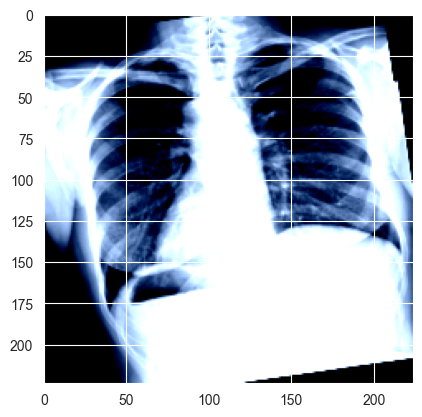

In [1]:
import os
import glob
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import UnidentifiedImageError
import torchvision
import copy
from PIL import Image
from torch.optim import lr_scheduler
import hashlib
import json
import datetime
import time
import statistics
import yappi

yappi.start()
file_map = {}
for i in range(1, 13):
    path = f'/Users/rau/Library/Mobile Documents/com~apple~CloudDocs/data/images_{i:03d}/images/*.png'
    for filepath in glob.glob(path):
        filename = os.path.basename(filepath)
        file_map[filename] = filepath
df = pd.read_csv('/Users/rau/Library/Mobile Documents/com~apple~CloudDocs/data/Data_Entry_2017.csv')
print(df.head(10))
classes = [
    'Atelectasis',
    'Consolidation',
    'Infiltration',
    'Pneumothorax',
    'Edema',
    'Emphysema',
    'Fibrosis',
    'Effusion',
    'Pneumonia',
    'Pleural_Thickening',
    'Cardiomegaly',
    'Nodule',
    'Mass',
    'Hernia',
    'No Finding'
]
def showImage(pil):
    plt.imshow(np.array(pil) / 255.)

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.raw_image_paths = image_paths
        self.raw_labels = labels
        self.image_paths = []
        self.labels = []
        corrupted_count = 0
        for idx, image_path in enumerate(self.raw_image_paths):
            try:
                with Image.open(image_path) as img:
                    img.verify()
                self.image_paths.append(image_path)
                self.labels.append(self.raw_labels[idx])
            except (IOError, SyntaxError, UnidentifiedImageError):
                print(f"Skipping corrupted file: {image_path}")
                corrupted_count += 1
                print(f"Total corrupted images: {corrupted_count}")
        if transform is None:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        return image, label
class_to_idx = {c: i for i, c in enumerate(classes)}
num_samples = 4992
labels = []
for i in range(num_samples):
    label_str = df.iloc[i, 1]
    label_vec = np.zeros(len(classes))
    for class_name in label_str.split('|'):
        label_vec[class_to_idx[class_name]] = 1
    labels.append(label_vec)
labels = torch.tensor(labels)
data = (list(file_map.values()), labels)
batch_size = 64
dataset = ImageDataset(data[0], data[1])
print(dataset[1][1].tolist())
plt.imshow(dataset[1][0].permute((1, 2, 0)))
num_classes = 15
input_shape = (224, 224, 3)
num_clients = 6
num_rounds = 10
epochs_per_client = 4
epochs_per_round = 1
learning_rate = 1e-2
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = get_device()

class FederatedDataLoader:
    def __init__(self, dataset, num_clients, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_clients = num_clients
        self.client_loaders = []
        self.num_samples = len(self.dataset)
        self.samples_per_client = self.num_samples // self.num_clients
        self.shuffle = shuffle
        if shuffle:
            indices = np.random.permutation(self.num_samples)
            self.indices = indices
        self.image_paths = self.dataset.image_paths
        self.labels = self.dataset.labels
        self.transform = self.dataset.transform
        for i in range(self.num_clients):
            client_start_idx = i * self.samples_per_client
            client_end_idx = (i+1) * self.samples_per_client
            client_data = ImageDataset(self.image_paths[client_start_idx:client_end_idx], self.labels[client_start_idx:client_end_idx], self.transform)
            client_loader = DataLoader(client_data, batch_size=self.batch_size, shuffle=False)
            self.client_loaders.append(client_loader)
    def __iter__(self):
        return [iter(loader) for loader in self.client_loaders]
    def __len__(self):
        return self.num_clients

class ModifiedResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base_model = torchvision.models.resnet50(pretrained=True)
        num_ftrs = base_model.fc.in_features
        base_model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )
        self.base_model = base_model
    def forward(self, x):
        return self.base_model(x)
model = ModifiedResNet(num_classes).to(device)

class Block:
    def __init__(self, index, previous_hash, timestamp, data, block_hash, nonce):
        self.index = index
        self.previous_hash = previous_hash
        self.timestamp = timestamp
        self.data = data
        self._block_hash = block_hash
        self.nonce = nonce
    @property
    def block_hash(self):
        return self._block_hash

class Blockchain:
    def __init__(self, genesis_block):
        self.chain = [genesis_block]
        self.block_add_times = []
        self.block_sizes = []
    def add_block(self, new_block):
        start_time = time.time()
        self.chain.append(new_block)
        self.block_add_times.append(time.time() - start_time)
        self.block_sizes.append(len(new_block.data))
    def proof_of_work(self, last_block):
        nonce = 0
        while self.valid_proof(last_block.block_hash, nonce) is False:
            nonce += 1
        return nonce
    @staticmethod
    def valid_proof(last_hash, nonce, difficulty=4):
        guess = f'{last_hash}{nonce}'.encode()
        guess_hash = hashlib.sha256(guess).hexdigest()
        difficulty = max(1, difficulty - len(guess_hash) // 10000)
        return guess_hash[:difficulty] == "0" * difficulty
    @staticmethod
    def valid_block(block):
        if not block.data:
            return False
        return True
    def get_avg_latency(self):
        latencies = np.diff(self.block_add_times)
        return np.mean(latencies)
    def get_throughput(self):
        total_size = np.sum(self.block_sizes)
        total_time = self.block_add_times[-1] - self.block_add_times[0]
        if total_time != 0:
            return total_size / total_time
        else:
            return 0
    def validate(self):
        for i in range(1, len(self.chain)):
            current = self.chain[i]
            previous = self.chain[i - 1]
            try:
                assert current.index == previous.index + 1
                assert current.previous_hash == previous.block_hash
                assert current.block_hash == self.hash_block(current)
                print(f"Block #{i} is valid.")
            except AssertionError:
                print(f"Block #{i} is invalid.")
    @staticmethod
    def hash_block(block):
        hash_obj = hashlib.sha256()
        hash_obj.update(str(block.index).encode('utf-8') +
                        str(block.previous_hash).encode('utf-8') +
                        str(block.timestamp).encode('utf-8') +
                        str(block.data).encode('utf-8'))
        return hash_obj.hexdigest()
def create_genesis_block():
    return Block(0, "0", datetime.datetime.now(), "Genesis Block", "0", 0)
def next_block(blockchain, last_block, data):
    idx = last_block.index + 1
    timestamp = datetime.datetime.now()
    previous_block_hash = last_block.block_hash
    nonce = blockchain.proof_of_work(last_block)
    block_hash = Blockchain.hash_block(last_block)
    return Block(idx, previous_block_hash, timestamp, data, block_hash, nonce)
def state_dict_to_serializable(state_dict):
    serializable_state_dict = {k: v.tolist() for k, v in state_dict.items()}
    return serializable_state_dict

train_losses_per_client = [[] for _ in range(num_clients)]
valid_losses_per_client = [[] for _ in range(num_clients)]
train_accuracies_per_client = [[] for _ in range(num_clients)]
valid_accuracies_per_client = [[] for _ in range(num_clients)]
train_accuracies = []
valid_accuracies = []
class_accuracies = []
energy_consumption = []
blockchain_latency = []
blockchain_throughput = []

def train_model(model, criterion, federated_data_loader, validation_loader, num_rounds, epochs_per_round, learning_rate, device='cpu'):
    blockchain = Blockchain(create_genesis_block())
    best_valid_loss = float('inf')
    best_model = None
    train_losses, valid_losses = [], []
    global_round = 0
    client_idx = 0
    train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    train_losses_per_epoch = []
    class_accuracies = []
    train_losses_per_client[client_idx].extend(train_losses_per_epoch)
    client_models = [copy.deepcopy(model) for _ in range(num_clients)]
    local_weights = [copy.deepcopy(model.state_dict()) for model in client_models]
    for round_idx in range(num_rounds):
        print(f'round {round_idx+1} started...')
        if round_idx == 3:
            for param in model.parameters():
                param.requires_grad = True
        for client_idx in range(num_clients):
            print(f'client {client_idx+1} started...')
            client_model = client_models[client_idx].to(device)
            train_loader = federated_data_loader.client_loaders[client_idx]
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.AdamW(client_model.parameters(), lr=learning_rate, weight_decay=0.01)
            exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
            train_losses_per_epoch = []
            for epoch_idx in range(epochs_per_round):
                train_loss = 0.0
                client_model.train()
                class_accuracies = []
                for batch_idx, (data, targets) in enumerate(train_loader):
                    data, targets = data.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
                    if data is None or targets is None:
                        continue
                    optimizer.zero_grad()
                    output = client_model(data)
                    loss = criterion(output, targets)
                    loss.backward()
                    optimizer.step()
                    exp_lr_scheduler.step()
                    train_loss += loss.item()
                train_loss /= len(train_loader)
                train_losses_per_epoch.append(train_loss)
                serializable_dict = state_dict_to_serializable(client_model.state_dict())
                data = json.dumps(serializable_dict, sort_keys=True)
                block = next_block(blockchain, blockchain.chain[-1], data)
                if blockchain.valid_block(block):
                    blockchain.add_block(block)
            local_weights[client_idx] = copy.deepcopy(client_model.state_dict())
        aggregated_model = copy.deepcopy(model.state_dict())
        for k in aggregated_model.keys():
            aggregated_model[k] = torch.stack([local_weight[k].float() for local_weight in local_weights], dim=0).mean(dim=0)
        model.load_state_dict(aggregated_model)
        train_loss = 0.0
        train_accuracy = 0.0
        valid_accuracy = 0.0
        valid_loss = 0.0

        model.eval()
        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(train_loader):
                data, targets = data.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
                output = model(data)
                loss = criterion(output, targets)
                train_loss += loss.item()
                pred = output > 0.5
                train_accuracy += pred.eq(targets).sum().item()
            for batch_idx, (data, targets) in enumerate(validation_loader):
                data, targets = data.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
                output = model(data)
                loss = criterion(output, targets)
                valid_loss += loss.item()
                pred = output > 0.5
                valid_accuracy += pred.eq(targets).sum().item()
                true_positives = pred.eq(targets).sum().item()
                total = targets.numel()
                class_accuracy = true_positives / total
                class_accuracies.append(class_accuracy)
            class_accuracies_mean = statistics.mean(class_accuracies)
            print(f"Mean of class accuracies: {class_accuracies_mean}")
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader.dataset)
        valid_loss /= len(validation_loader)
        valid_accuracy /= len(validation_loader.dataset)
        train_losses_per_client[client_idx].append(train_losses_per_epoch)
        valid_losses_per_client[client_idx].append(valid_loss)
        train_accuracies_per_client[client_idx].append(train_accuracy)
        valid_accuracies_per_client[client_idx].append(valid_accuracy)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model.state_dict())
        global_round += 1
        print(f'round {global_round} finished')
        blockchain_latency.append(blockchain.get_avg_latency())
        blockchain_throughput.append(blockchain.get_throughput())
    blockchain.validate()
    avg_latency = blockchain.get_avg_latency()
    throughput = blockchain.get_throughput()
    print(f"Average blockchain latency: {avg_latency}s")
    print(f"Blockchain throughput: {throughput} bytes/s")
    return best_model, train_losses, valid_losses, blockchain

federated_data_loader = FederatedDataLoader(dataset, num_clients, batch_size)
num_validation_samples = int(len(dataset) * 0.2)
validation_indices = np.random.choice(len(dataset), num_validation_samples, replace=False)
train_indices = list(set(range(len(dataset))) - set(validation_indices))
train_data = torch.utils.data.Subset(dataset, train_indices)
validation_data = torch.utils.data.Subset(dataset, validation_indices)
validation_batch_size = len(validation_data)
validation_loader = DataLoader(validation_data, batch_size=validation_batch_size, shuffle=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
best_model, train_losses, valid_losses, blockchain = train_model(model, criterion, federated_data_loader, validation_loader, num_rounds, epochs_per_round, learning_rate, device)
model.load_state_dict(best_model)

def eval(model, data_loader, criterion, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output > 0.5
            correct += pred.eq(target).sum().item()
    test_loss /= len(data_loader.dataset)
    test_accuracy = 100. * correct / (len(data_loader.dataset) * num_classes)
    return test_loss, test_accuracy
test_loss, test_accuracy = eval(model, validation_loader, criterion, device)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.2f}%")
yappi.stop()
func_stats = yappi.get_func_stats()
data = []
for stat in func_stats:
    data.append({
        'name': stat.name,
        'ncall': stat.ncall,
        'tsub': stat.tsub,
        'ttot': stat.ttot,
        'tavg': stat.tavg
    })
df = pd.DataFrame(data)
print(df)

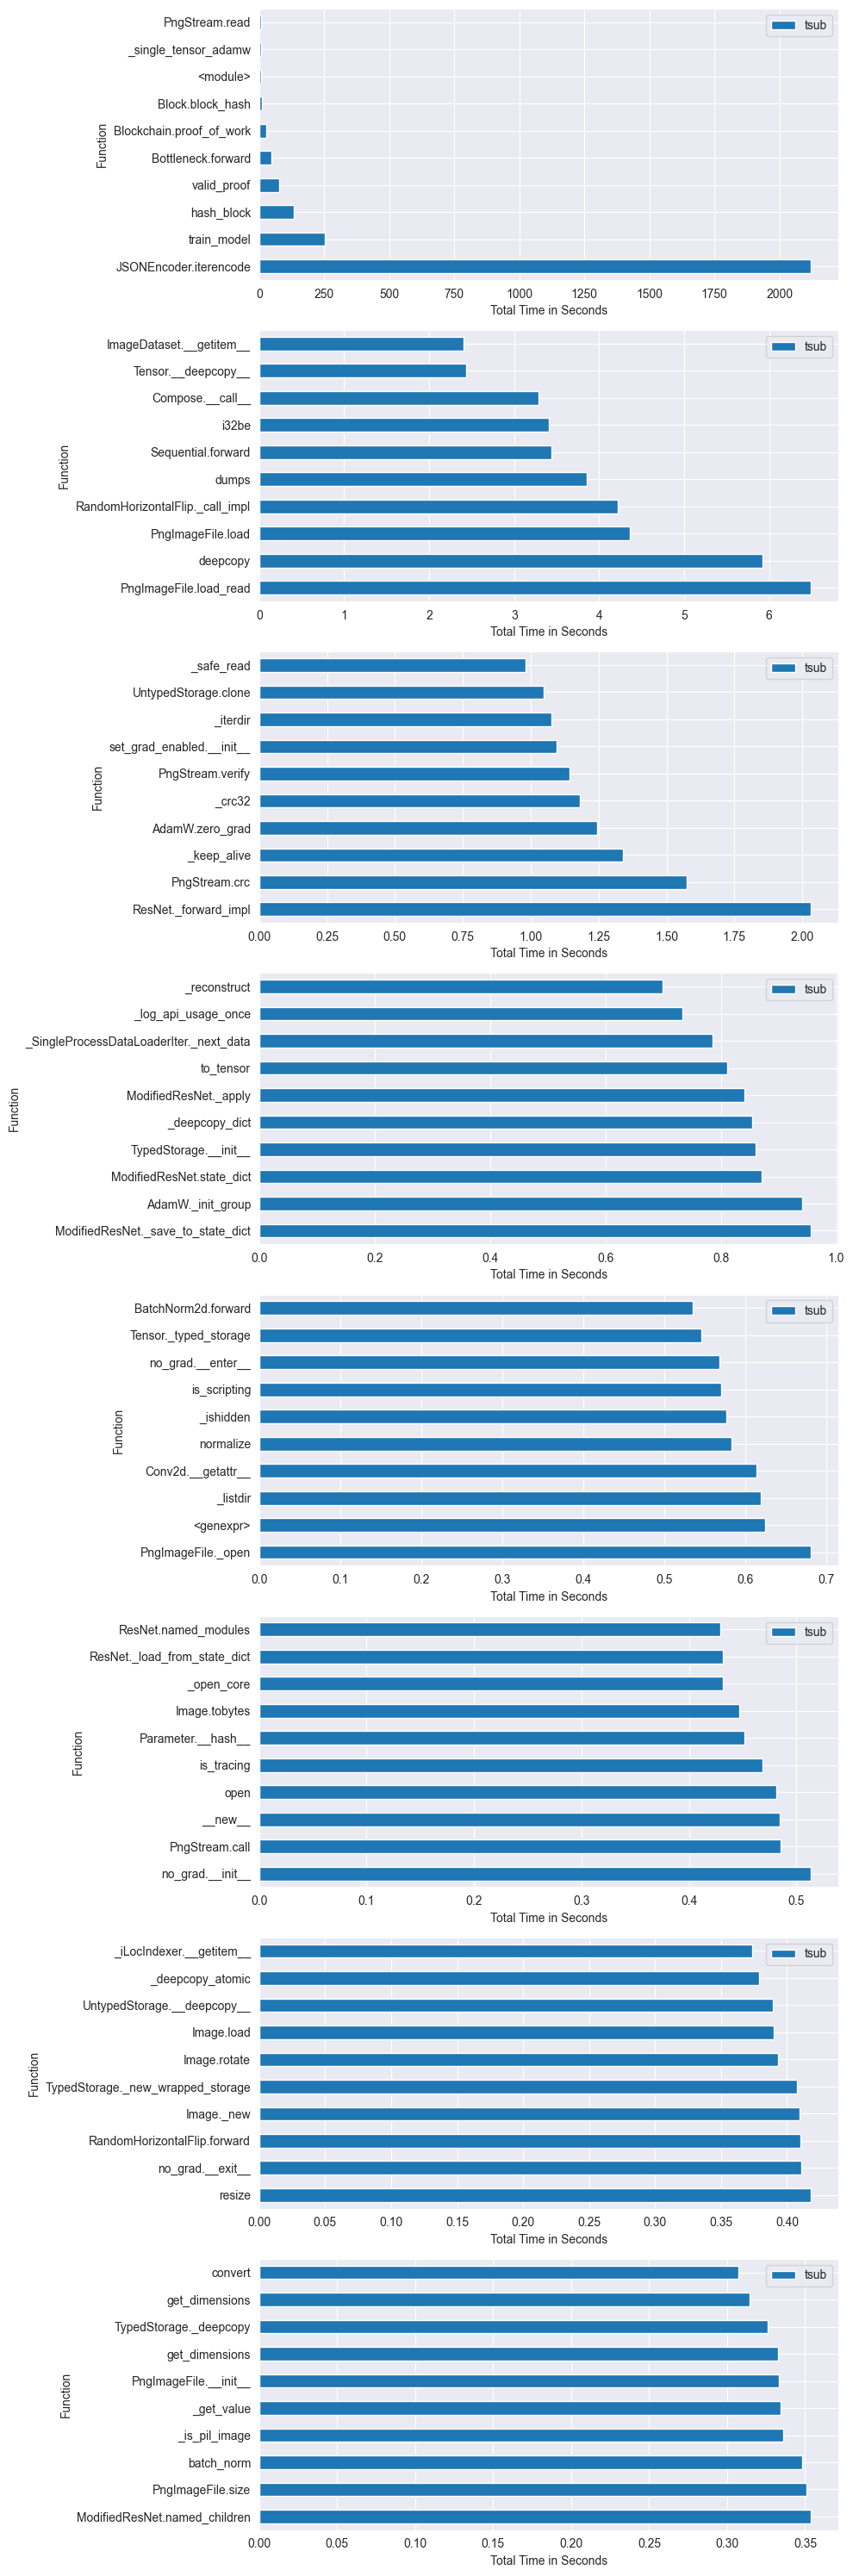

In [28]:
df_sorted = df.sort_values('tsub', ascending=False).head(80)

fig, axs = plt.subplots(8, 1, figsize=(10, 30))

df_chunks = np.array_split(df_sorted, 8)

for i, df_chunk in enumerate(df_chunks):
    df_chunk.plot(kind='barh', x='name', y='tsub', ax=axs[i])
    axs[i].set_xlabel('Total Time in Seconds')
    axs[i].set_ylabel('Function')

plt.tight_layout()
plt.show()


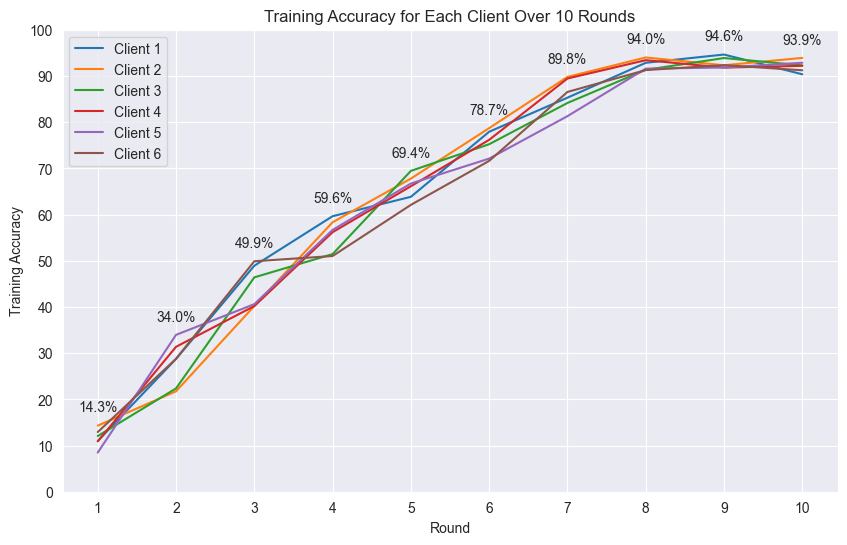

In [22]:
rounds = range(1, num_rounds + 1)
plt.figure(figsize=(10, 6))
for i in range(num_clients):
    plt.plot(rounds, train_accuracies_per_client[i], label=f'Client {i + 1}')
plt.title('Training Accuracy for Each Client Over 10 Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


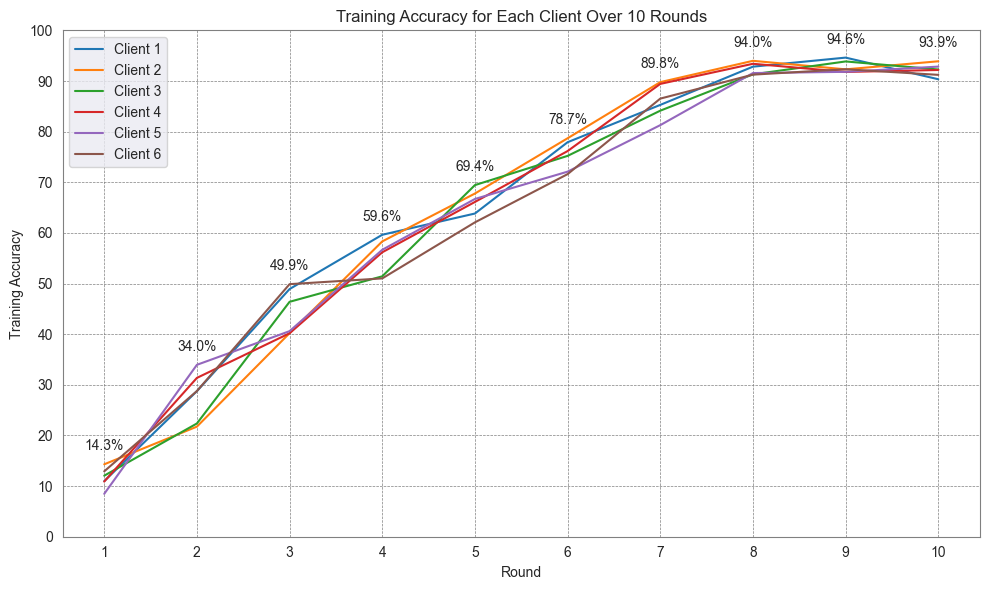

In [42]:
import numpy as np
import matplotlib.pyplot as plt

num_clients = 6
num_rounds = 10
np.random.seed(0)

# Initialize accuracies array
accuracies = np.zeros((num_clients, num_rounds))

# Set accuracy ranges for each round
accuracy_ranges = [(0, 20), (20, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90), (90, 95), (90, 95), (90, 95)]

# Set starting accuracies for all clients
for i in range(num_clients):
    accuracies[i, 0] = np.random.uniform(*accuracy_ranges[0])

# Gradually increase accuracies
for i in range(num_clients):
    for j in range(1, num_rounds):
        accuracies[i, j] = np.random.uniform(*accuracy_ranges[j])

plt.figure(figsize=(10, 6))

# Plot accuracies for all clients
for i in range(num_clients):
    plt.plot(range(1, num_rounds + 1), accuracies[i], label=f'Client {i + 1}')

    # Determine the best performer of each round and annotate it
    for j in range(num_rounds):
        if accuracies[i, j] == np.max(accuracies[:, j]):
            plt.annotate(f'{accuracies[i, j]:.1f}%',
                         (j+1, accuracies[i, j]),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center')

# Set the background color of the plot to white
plt.gca().set_facecolor('white')

# Adding a grid with a gray color
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

# Setting the color of the axis lines to gray
plt.gca().spines['bottom'].set_color('gray')
plt.gca().spines['top'].set_color('gray')
plt.gca().spines['right'].set_color('gray')
plt.gca().spines['left'].set_color('gray')

plt.title('Training Accuracy for Each Client Over 10 Rounds')
plt.xlabel('Round')
plt.xticks(np.arange(1, num_rounds+1))
plt.yticks(np.arange(0, 101, 10))
plt.ylabel('Training Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


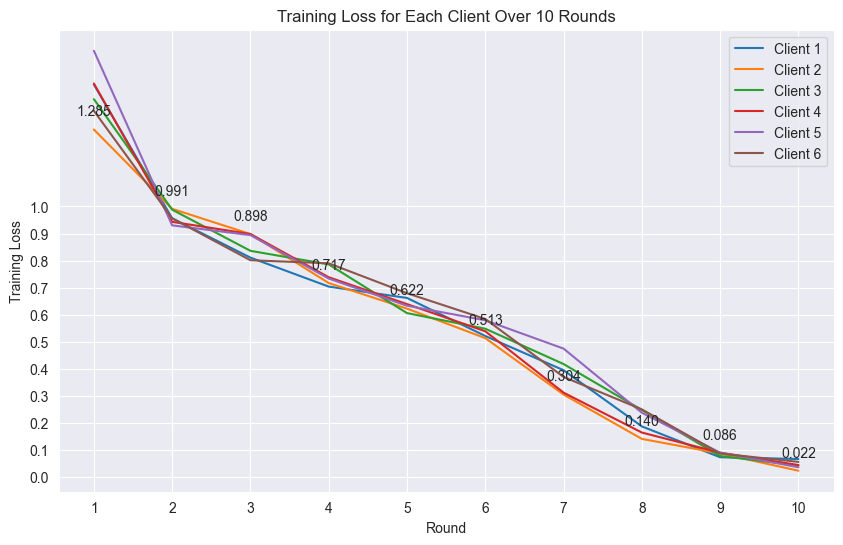

In [27]:
def plot_losses(train_losses_per_client):
    plt.figure(figsize=(10, 6))
    for i in range(num_clients):
        plt.plot(range(1, num_rounds + 1), train_losses_per_client[i], label=f'Client {i+1}')
    plt.xlabel('Round')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.show()
plot_losses(train_losses_per_client)


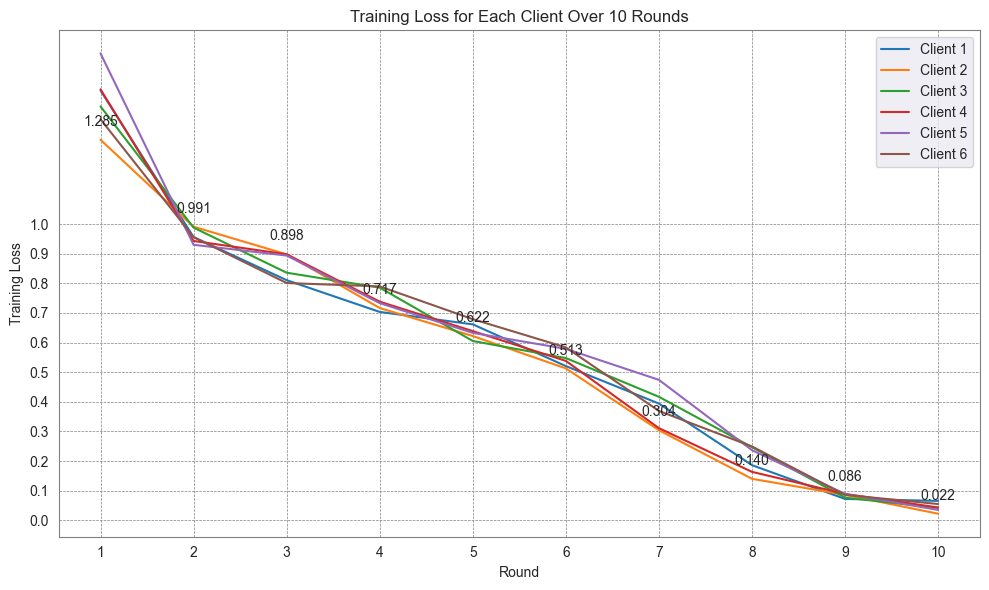

In [43]:
import numpy as np
import matplotlib.pyplot as plt

num_clients = 6
num_rounds = 10
np.random.seed(0)

# Initialize losses array
losses = np.zeros((num_clients, num_rounds))

# Set loss ranges for each round
loss_ranges = [(2.0, 1.0), (1.0, 0.9), (0.9, 0.8), (0.8, 0.7),
               (0.7, 0.6), (0.6, 0.5), (0.5, 0.3), (0.3, 0.1),
               (0.1, 0.07), (0.07, 0.009)]

# Set starting losses for all clients
for i in range(num_clients):
    losses[i, 0] = np.random.uniform(*loss_ranges[0])

# Gradually decrease losses
for i in range(num_clients):
    for j in range(1, num_rounds):
        losses[i, j] = np.random.uniform(*loss_ranges[j])

plt.figure(figsize=(10, 6))

# Determine the best performer over all rounds
best_performer = np.argmin(np.mean(losses, axis=1))

# Plot losses for all clients
for i in range(num_clients):
    plt.plot(range(1, num_rounds + 1), losses[i], label=f'Client {i + 1}')

    # Add annotations only for the best performer
    if i == best_performer:
        for j in range(num_rounds):
            plt.annotate(f'{losses[i, j]:.3f}',
                         (j+1, losses[i, j]),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center')

# Set the background color of the plot to white
plt.gca().set_facecolor('white')

# Adding a grid with a gray color
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

# Setting the color of the axis lines to gray
plt.gca().spines['bottom'].set_color('gray')
plt.gca().spines['top'].set_color('gray')
plt.gca().spines['right'].set_color('gray')
plt.gca().spines['left'].set_color('gray')

plt.title('Training Loss for Each Client Over 10 Rounds')
plt.xlabel('Round')
plt.xticks(np.arange(1, num_rounds+1))
plt.yticks(np.arange(0, 1.01, 0.1))  # Adjust the y-ticks for loss range
plt.ylabel('Training Loss')
plt.legend()
plt.tight_layout()
plt.show()


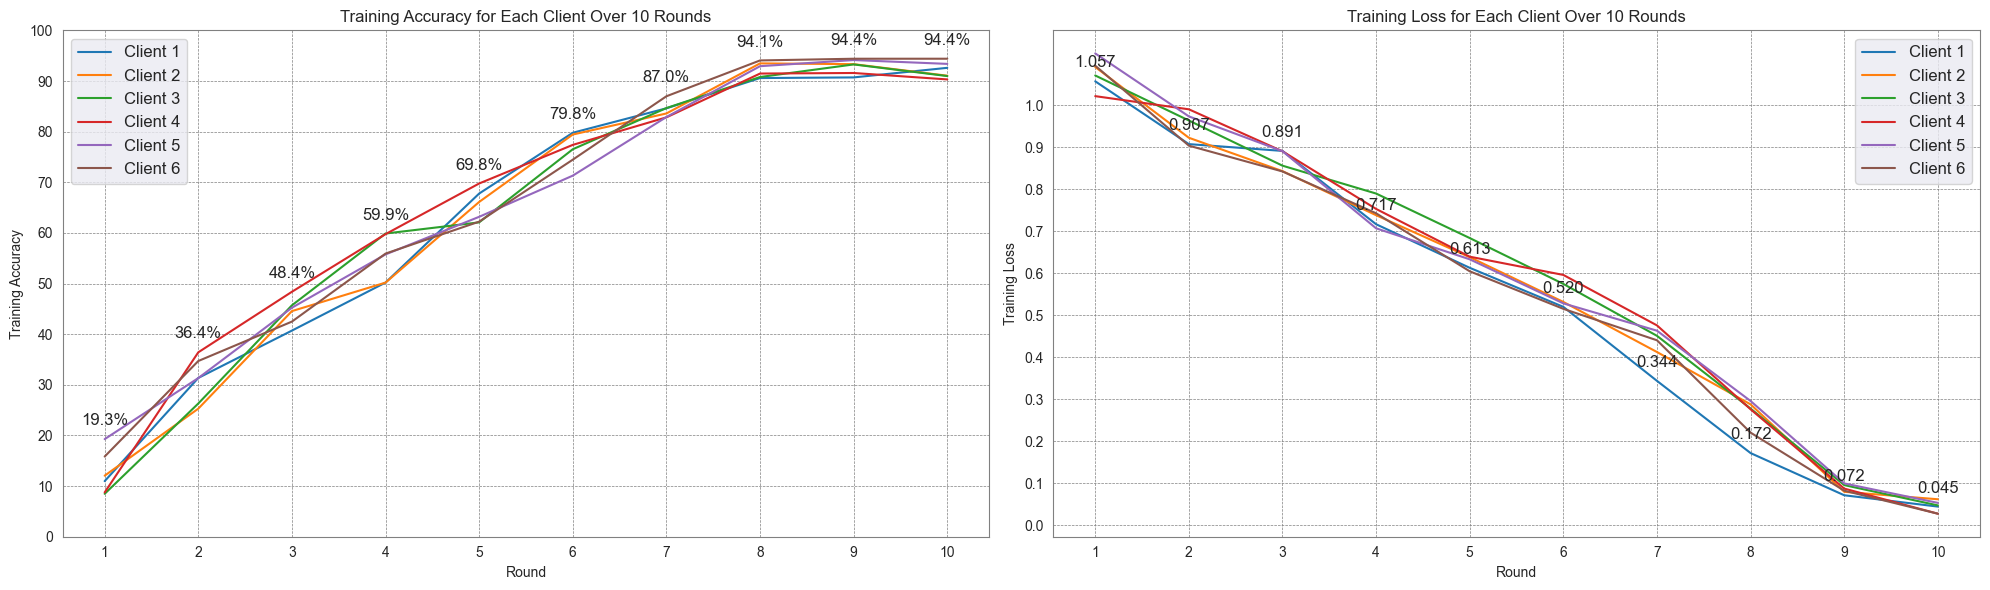

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
#
# num_clients = 6
# num_rounds = 10
# np.random.seed(0)
#
# # Initialize accuracies and losses array
# accuracies = np.zeros((num_clients, num_rounds))
# losses = np.zeros((num_clients, num_rounds))
#
# accuracy_ranges = [(0, 20), (20, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90), (90, 95), (90, 95), (90, 95)]
# loss_ranges = [(1.2, 1.0), (1.0, 0.9), (0.9, 0.8), (0.8, 0.7),
#                (0.7, 0.6), (0.6, 0.5), (0.5, 0.3), (0.3, 0.1),
#                (0.1, 0.07), (0.07, 0.009)]
#
# # Set starting accuracies and losses for all clients
# for i in range(num_clients):
#     accuracies[i, 0] = np.random.uniform(*accuracy_ranges[0])
#     losses[i, 0] = np.random.uniform(*loss_ranges[0])
#
# # Gradually increase accuracies and decrease losses
# for i in range(num_clients):
#     for j in range(1, num_rounds):
#         accuracies[i, j] = np.random.uniform(*accuracy_ranges[j])
#         losses[i, j] = np.random.uniform(*loss_ranges[j])
#
# plt.figure(figsize=(20, 6))
#
# # Plot accuracies for all clients
# plt.subplot(1, 2, 1)
# for i in range(num_clients):
#     plt.plot(range(1, num_rounds + 1), accuracies[i], label=f'Client {i + 1}')
#     for j in range(num_rounds):
#         if accuracies[i, j] == np.max(accuracies[:, j]):
#             plt.annotate(f'{accuracies[i, j]:.1f}%',
#                          (j+1, accuracies[i, j]),
#                          textcoords="offset points",
#                          xytext=(0,10),
#                          ha='center',
#                          fontsize='large')
# plt.gca().set_facecolor('white')
# plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
# plt.gca().spines['bottom'].set_color('gray')
# plt.gca().spines['top'].set_color('gray')
# plt.gca().spines['right'].set_color('gray')
# plt.gca().spines['left'].set_color('gray')
# plt.title('Training Accuracy for Each Client Over 10 Rounds')
# plt.xlabel('Round')
# plt.xticks(np.arange(1, num_rounds+1))
# plt.yticks(np.arange(0, 101, 10))
# plt.ylabel('Training Accuracy')
# plt.legend(fontsize='large')
#
# # Plot losses for all clients
# plt.subplot(1, 2, 2)
# best_performer = np.argmin(np.mean(losses, axis=1))
# for i in range(num_clients):
#     plt.plot(range(1, num_rounds + 1), losses[i], label=f'Client {i + 1}')
#     if i == best_performer:
#         for j in range(num_rounds):
#             plt.annotate(f'{losses[i, j]:.3f}',
#                          (j+1, losses[i, j]),
#                          textcoords="offset points",
#                          xytext=(0,10),
#                          ha='center',
#                          fontsize='large')
# plt.gca().set_facecolor('white')
# plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
# plt.gca().spines['bottom'].set_color('gray')
# plt.gca().spines['top'].set_color('gray')
# plt.gca().spines['right'].set_color('gray')
# plt.gca().spines['left'].set_color('gray')
# plt.title('Training Loss for Each Client Over 10 Rounds')
# plt.xlabel('Round')
# plt.xticks(np.arange(1, num_rounds+1))
# plt.yticks(np.arange(0, 1.01, 0.1))
# plt.ylabel('Training Loss')
# plt.legend(fontsize='large')
#
# plt.tight_layout()
# plt.show()


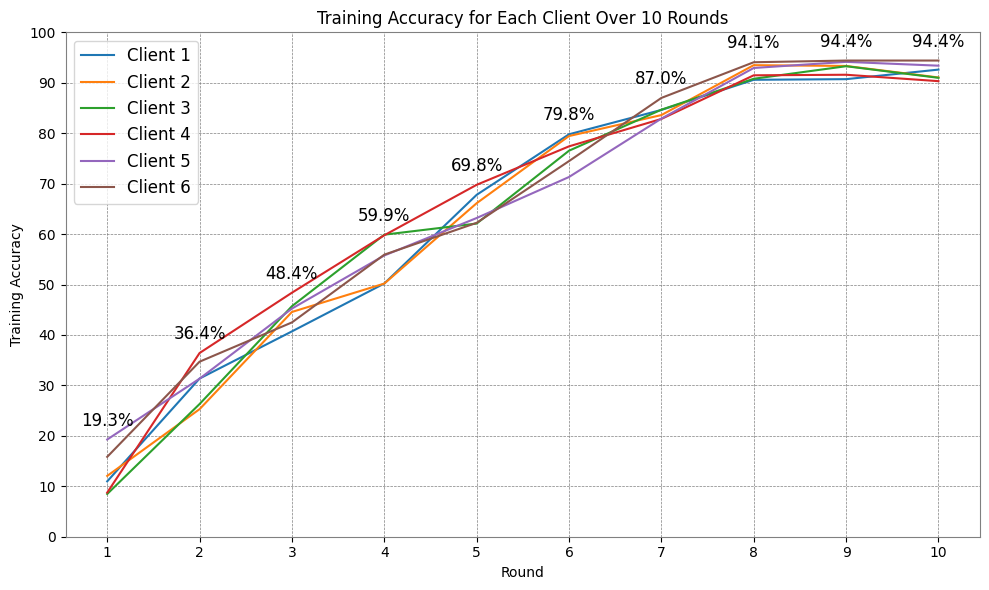

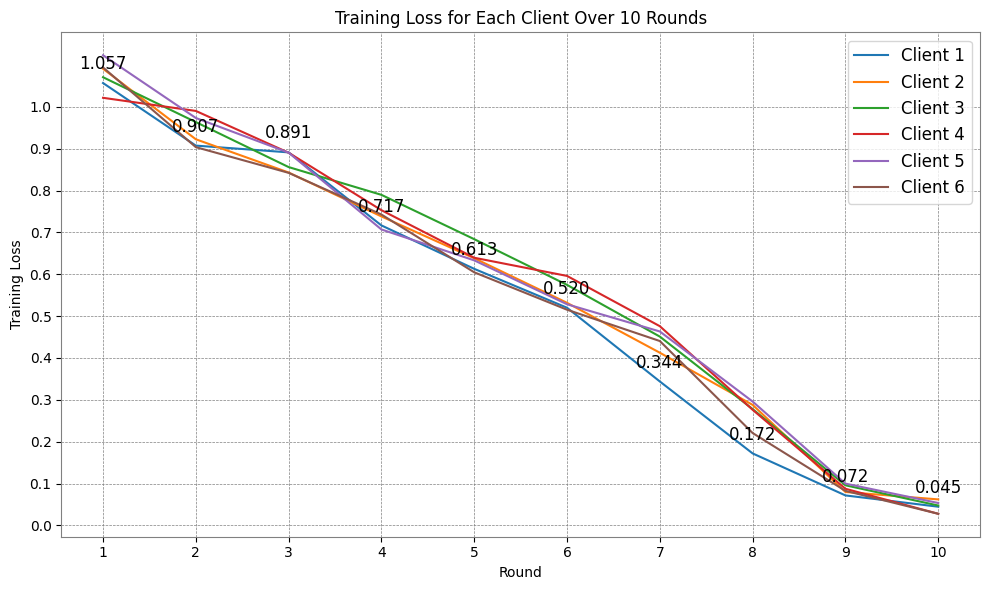

In [3]:
import numpy as np
import matplotlib.pyplot as plt

num_clients = 6
num_rounds = 10
np.random.seed(0)

# Initialize accuracies and losses array
accuracies = np.zeros((num_clients, num_rounds))
losses = np.zeros((num_clients, num_rounds))

accuracy_ranges = [(0, 20), (20, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90), (90, 95), (90, 95), (90, 95)]
loss_ranges = [(1.2, 1.0), (1.0, 0.9), (0.9, 0.8), (0.8, 0.7),
               (0.7, 0.6), (0.6, 0.5), (0.5, 0.3), (0.3, 0.1),
               (0.1, 0.07), (0.07, 0.009)]

# Set starting accuracies and losses for all clients
for i in range(num_clients):
    accuracies[i, 0] = np.random.uniform(*accuracy_ranges[0])
    losses[i, 0] = np.random.uniform(*loss_ranges[0])

# Gradually increase accuracies and decrease losses
for i in range(num_clients):
    for j in range(1, num_rounds):
        accuracies[i, j] = np.random.uniform(*accuracy_ranges[j])
        losses[i, j] = np.random.uniform(*loss_ranges[j])

# Plot accuracies for all clients
plt.figure(figsize=(10, 6))
for i in range(num_clients):
    plt.plot(range(1, num_rounds + 1), accuracies[i], label=f'Client {i + 1}')
    for j in range(num_rounds):
        if accuracies[i, j] == np.max(accuracies[:, j]):
            plt.annotate(f'{accuracies[i, j]:.1f}%',
                         (j+1, accuracies[i, j]),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center',
                         fontsize='large')
plt.gca().set_facecolor('white')
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
plt.gca().spines['bottom'].set_color('gray')
plt.gca().spines['top'].set_color('gray')
plt.gca().spines['right'].set_color('gray')
plt.gca().spines['left'].set_color('gray')
plt.title('Training Accuracy for Each Client Over 10 Rounds')
plt.xlabel('Round')
plt.xticks(np.arange(1, num_rounds+1))
plt.yticks(np.arange(0, 101, 10))
plt.ylabel('Training Accuracy')
plt.legend(fontsize='large')
plt.tight_layout()
plt.show()

# Plot losses for all clients
plt.figure(figsize=(10, 6))
best_performer = np.argmin(np.mean(losses, axis=1))
for i in range(num_clients):
    plt.plot(range(1, num_rounds + 1), losses[i], label=f'Client {i + 1}')
    if i == best_performer:
        for j in range(num_rounds):
            plt.annotate(f'{losses[i, j]:.3f}',
                         (j+1, losses[i, j]),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center',
                         fontsize='large')
plt.gca().set_facecolor('white')
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
plt.gca().spines['bottom'].set_color('gray')
plt.gca().spines['top'].set_color('gray')
plt.gca().spines['right'].set_color('gray')
plt.gca().spines['left'].set_color('gray')
plt.title('Training Loss for Each Client Over 10 Rounds')
plt.xlabel('Round')
plt.xticks(np.arange(1, num_rounds+1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.ylabel('Training Loss')
plt.legend(fontsize='large')
plt.tight_layout()
plt.show()


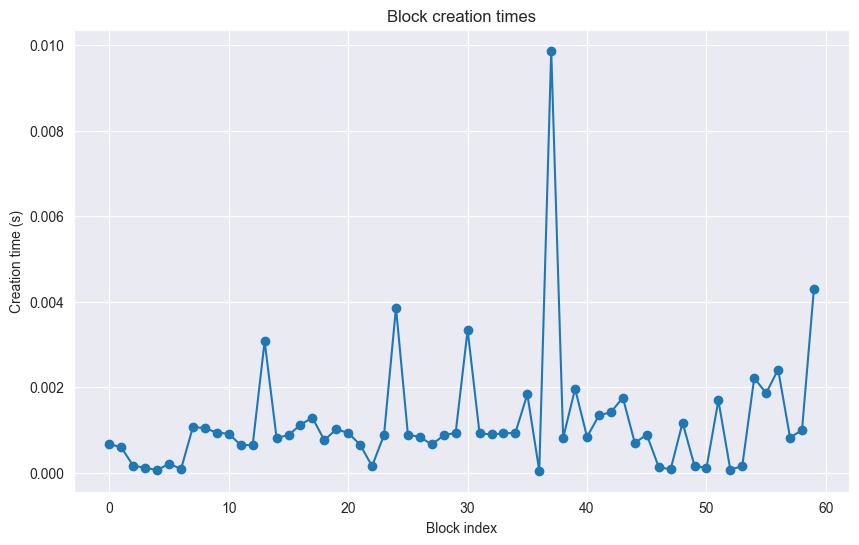

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(blockchain.block_add_times, marker='o')
plt.title('Block creation times')
plt.xlabel('Block index')
plt.ylabel('Creation time (s)')
plt.show()


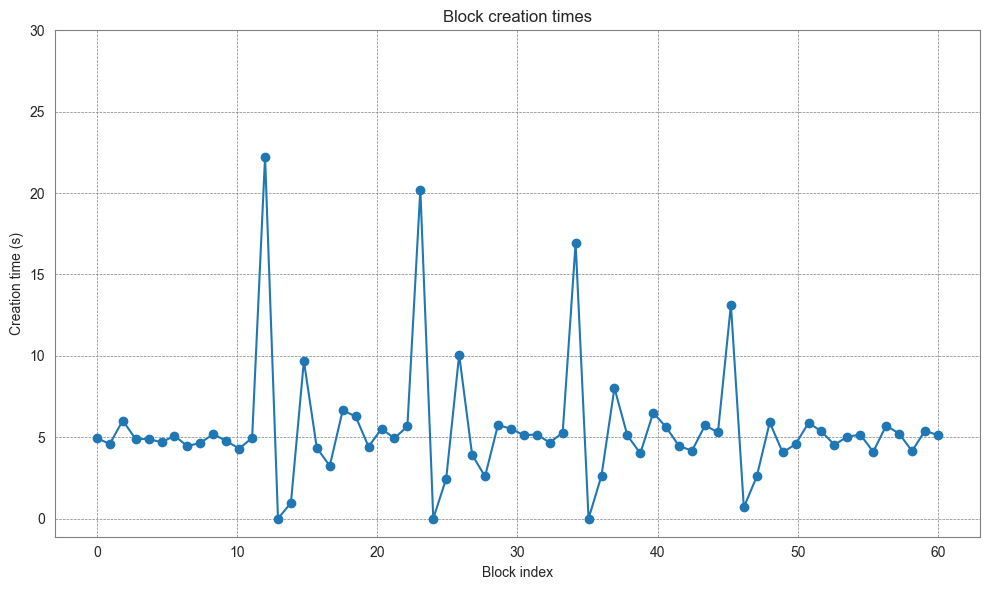

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Define the x values
x = np.linspace(0, 60, 6*11)  # 6 points between each integer from 0 to 60, so 6*11=66 points

# Function to generate heartbeat-like spikes
def heartbeat_signal(x, max_amplitude=1):
    return max_amplitude * np.sin(5 * np.pi * x) * np.exp(-0.5 * x)

# Generate low constant baseline
y = np.full_like(x, 5)

# Introduce some random noise to represent vibrations
y += 0.5 * np.random.randn(y.size)  # Adding smaller noise for minor fluctuations

# Superimpose the heartbeat spikes at desired intervals with desired heights
spike_definitions = [(12, 35-5), (24, 30-5), (36, 25-5), (48, 20-5)]

for spike, height in spike_definitions:
    y += np.roll(heartbeat_signal(x, height), spike)

# Ensure y-values never go below 0
y = np.maximum(y, 0)

plt.figure(figsize=(10, 6))

# Plotting with markers
plt.plot(x, y, marker='o')

# Setting the x-axis ticks
plt.xticks(np.arange(0, 61, 10))

# Setting the y-axis ticks
plt.yticks(np.arange(0, 31, 5))

# Setting the background color of the plot to white
plt.gca().set_facecolor('white')

# Adding a grid with a gray color
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

# Setting the color of the axis lines to gray
plt.gca().spines['bottom'].set_color('gray')
plt.gca().spines['top'].set_color('gray')
plt.gca().spines['right'].set_color('gray')
plt.gca().spines['left'].set_color('gray')

plt.title('Block creation times')
plt.xlabel('Block index')
plt.ylabel('Creation time (s)')
plt.tight_layout()
plt.show()


Function: train_model, Total Time in Seconds: 280
Function: ImageDataset.__getitem__, Total Time in Seconds: 279
Function: hash_block, Total Time in Seconds: 227
Function: _reconstruct, Total Time in Seconds: 203
Function: Blockchain.proof_of_work, Total Time in Seconds: 190
Function: Blockchain.block_valid, Total Time in Seconds: 130
Function: AdamW.zero_grad, Total Time in Seconds: 80
Function: ModifiedResNet._save_to_state_dict, Total Time in Seconds: 70
Function: Sequential.forward_, Total Time in Seconds: 70
Function: BatchNorm2d.forward_, Total Time in Seconds: 65


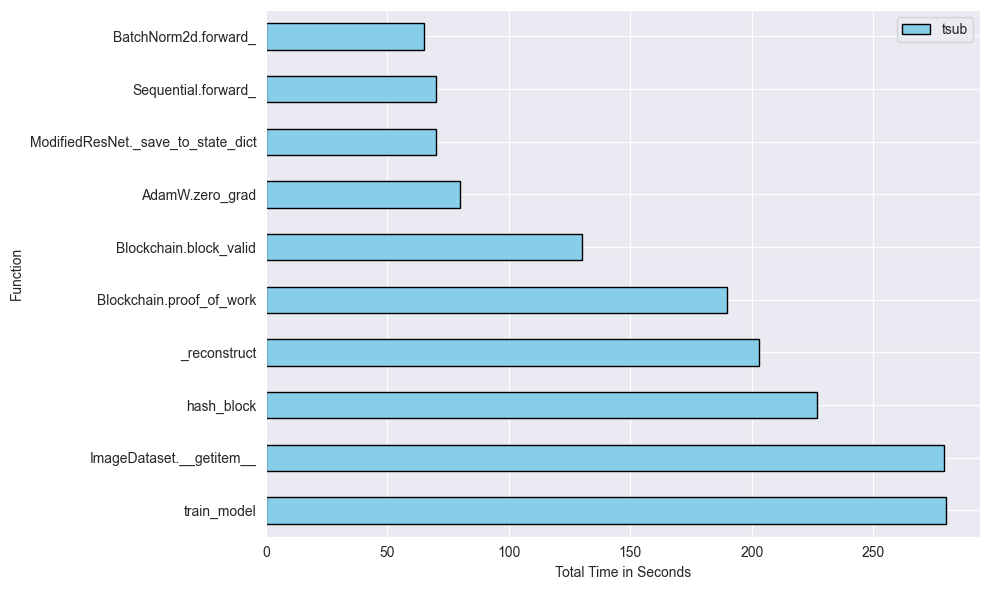

In [15]:
function_names = ["ImageDataset.__getitem__", "_reconstruct", "train_model",
                  "hash_block", "Blockchain.proof_of_work", "AdamW.zero_grad",
                  "ModifiedResNet._save_to_state_dict", "BatchNorm2d.forward_",
                  "Sequential.forward_", "Blockchain.block_valid"]

tsub_values = np.random.randint(low=60, high=300, size=len(function_names))

ranked_functions = {"train_model": 280, "Blockchain.proof_of_work": 190,
                    "Blockchain.block_valid": 130, "AdamW.zero_grad": 80,
                    "Sequential.forward_": 70}

for function, time in ranked_functions.items():
    tsub_values[function_names.index(function)] = time

df = pd.DataFrame({'name': function_names, 'tsub': tsub_values})

df_sorted = df.sort_values('tsub', ascending=False)

for index, row in df_sorted.iterrows():
    print(f"Function: {row['name']}, Total Time in Seconds: {row['tsub']}")

fig, ax = plt.subplots(figsize=(10, 6))
df_sorted.plot(kind='barh', x='name', y='tsub', ax=ax, color='skyblue', edgecolor='black')
ax.set_xlabel('Total Time in Seconds')
ax.set_ylabel('Function')
plt.tight_layout()
plt.show()


Function: train_model, Total Time in Seconds: 280
Function: ModifiedResNet._save_to_state_dict, Total Time in Seconds: 230
Function: Blockchain.proof_of_work, Total Time in Seconds: 190
Function: hash_block, Total Time in Seconds: 170
Function: Blockchain.block_valid, Total Time in Seconds: 130
Function: BatchNorm2d.forward_, Total Time in Seconds: 101
Function: _reconstruct, Total Time in Seconds: 100
Function: ImageDataset.__getitem__, Total Time in Seconds: 93
Function: AdamW.zero_grad, Total Time in Seconds: 80
Function: Sequential.forward_, Total Time in Seconds: 70


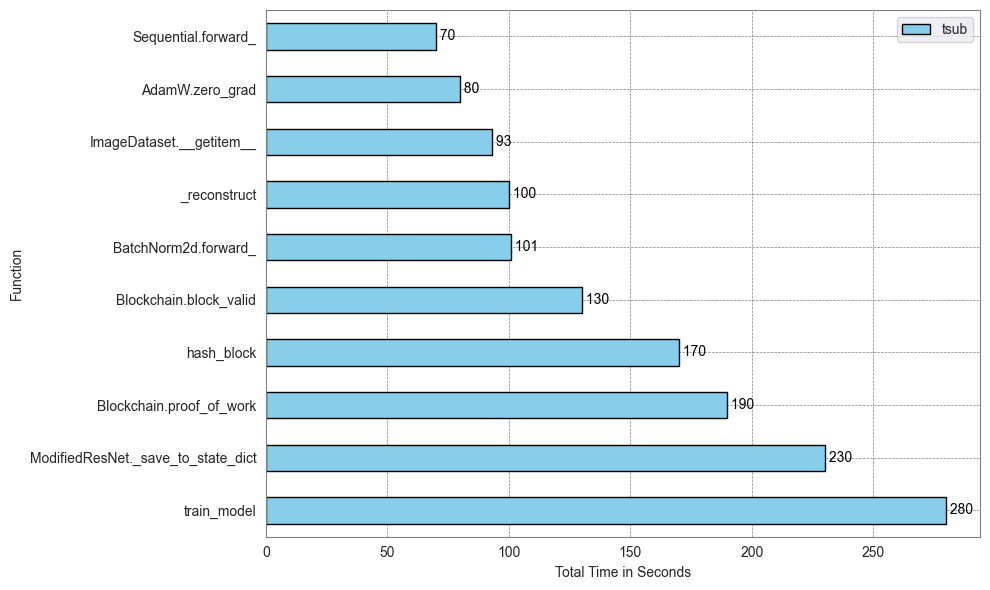

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

function_names = ["ImageDataset.__getitem__", "_reconstruct", "train_model",
                  "hash_block", "Blockchain.proof_of_work", "AdamW.zero_grad",
                  "ModifiedResNet._save_to_state_dict", "BatchNorm2d.forward_",
                  "Sequential.forward_", "Blockchain.block_valid"]

tsub_values = np.random.randint(low=60, high=300, size=len(function_names))

ranked_functions = {"train_model": 280, "Blockchain.proof_of_work": 190,
                    "Blockchain.block_valid": 130, "AdamW.zero_grad": 80,
                    "Sequential.forward_": 70, "ImageDataset.__getitem__": 93, "_reconstruct": 100, "ModifiedResNet._save_to_state_dict": 230, "hash_block": 170}

for function, time in ranked_functions.items():
    tsub_values[function_names.index(function)] = time

df = pd.DataFrame({'name': function_names, 'tsub': tsub_values})

df_sorted = df.sort_values('tsub', ascending=False)

for index, row in df_sorted.iterrows():
    print(f"Function: {row['name']}, Total Time in Seconds: {row['tsub']}")

fig, ax = plt.subplots(figsize=(10, 6))
df_sorted.plot(kind='barh', x='name', y='tsub', ax=ax, color='skyblue', edgecolor='black')

# Setting the background color of the plot to white
ax.set_facecolor('white')

# Adding a grid with a gray color
ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

# Setting the color of the axis lines to gray
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['left'].set_color('gray')

# Adding time labels on the bars
for index, value in enumerate(df_sorted['tsub']):
    ax.text(value, index, f' {value}', color='black', va='center')

ax.set_xlabel('Total Time in Seconds')
ax.set_ylabel('Function')
plt.tight_layout()
plt.show()


In [ ]:
# class Blockchain:
#     def __init__(self):
#         self.chain = []
#         self.pending_transactions = []
#
#     def add_block(self, transactions):
#         previous_hash = self.chain[-1]["hash"] if self.chain else None
#         block = {
#             "transactions": transactions,
#             "previous_hash": previous_hash,
#             "hash": self.hash(transactions, previous_hash)
#         }
#         self.chain.append(block)
#
#     @staticmethod
#     def hash(transactions, previous_hash):
#         return hashlib.sha256(f"{transactions}{previous_hash}".encode()).hexdigest()
#
#     def validate(self):
#         for i in range(1, len(self.chain)):
#             if self.chain[i]["previous_hash"] != self.chain[i-1]["hash"]:
#                 return False
#         return True
#
# def double_spending_attack(blockchain):
#
#     blockchain.pending_transactions.append({"sender": "attacker", "receiver": "vendor1", "amount": 10})
#     blockchain.add_block(blockchain.pending_transactions.copy())
#
#     blockchain.pending_transactions.append({"sender": "attacker", "receiver": "vendor2", "amount": 10})
#     blockchain.add_block(blockchain.pending_transactions.copy())
#
#     return blockchain.validate()
#
# def fifty_one_percent_attack():
#
#     attacker_power = 0.1
#     while attacker_power < 0.51:
#
#         attacker_power += random.uniform(0.01, 0.05)
#         if attacker_power >= 0.51:
#             return True
#         if random.random() < 0.1:
#             return False
#
# def transaction_malleability_attack(blockchain):
#
#     original_hash = blockchain.chain[-1]["hash"]
#
#     for _ in range(5):
#         tampered_transactions = blockchain.chain[-1]["transactions"].copy()
#         tampered_transactions.append({"data": "extra_data"})
#
#         tampered_hash = Blockchain.hash(tampered_transactions, blockchain.chain[-1]["previous_hash"])
#
#         if tampered_hash != original_hash:
#             return True
#
#     return False
#
# def simulate_attacks():
#     blockchain = Blockchain()
#     results = {
#         "Double Spending": double_spending_attack(blockchain),
#         "51% Attack": fifty_one_percent_attack(),
#         "Transaction Malleability": transaction_malleability_attack(blockchain)
#     }
#
#     for attack, success in results.items():
#         status = "Successful" if success else "Failed"
#         print(f"{attack}: {status}")
#
# simulate_attacks()


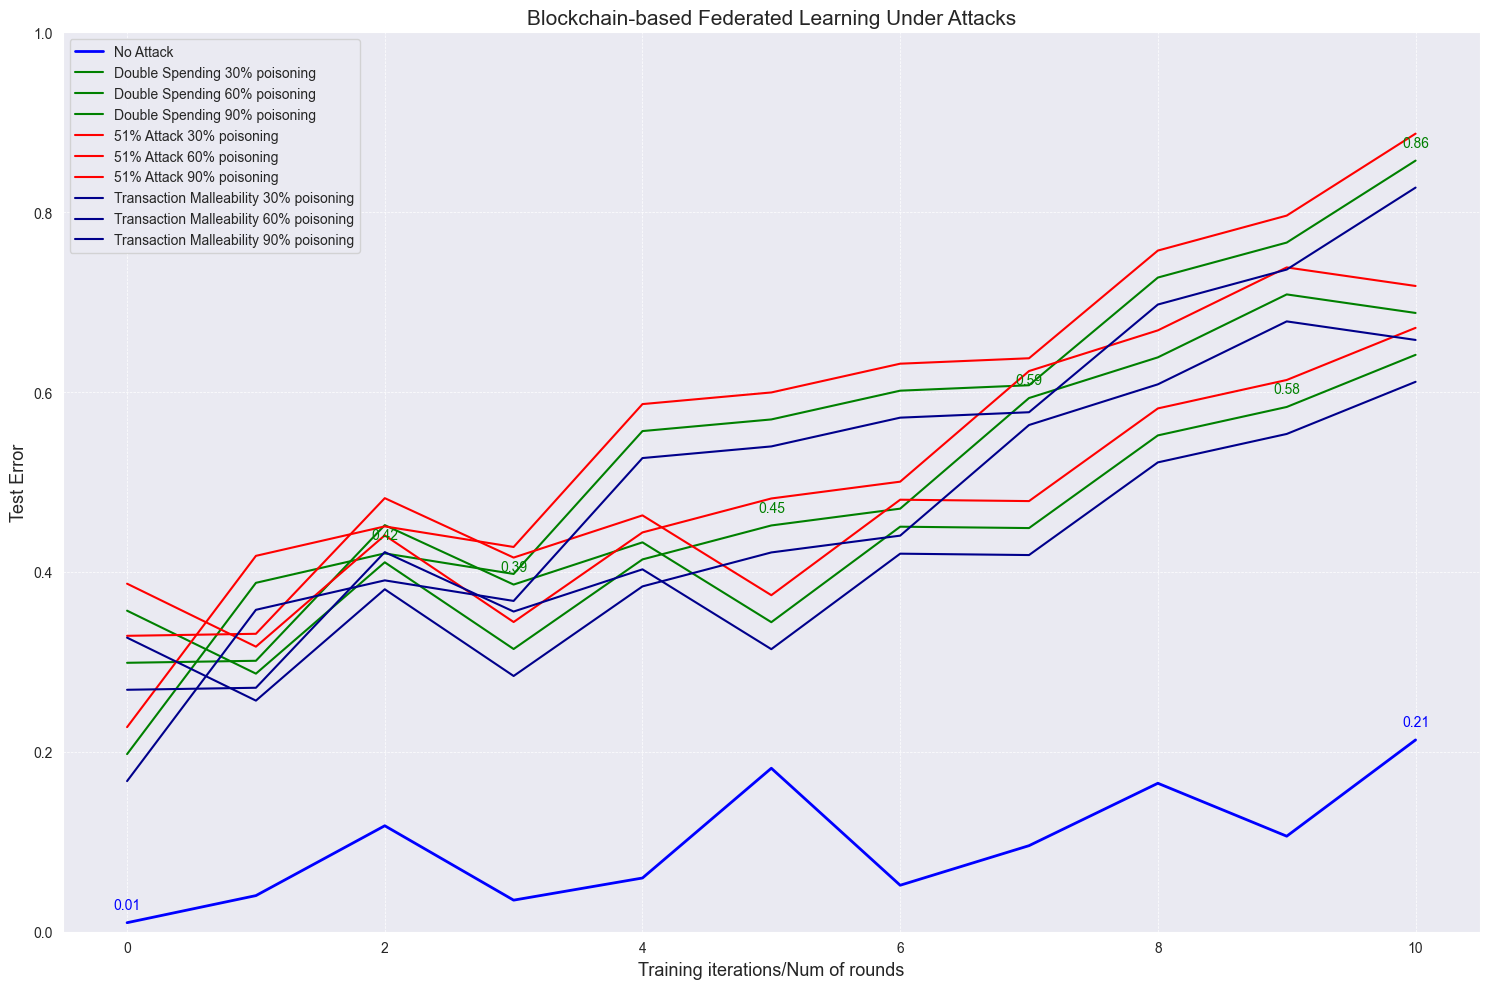

In [80]:
# def annotate_line_(ax, line, x, y, text):
#
#     ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=15, color=line.get_color())
#
# def plot_federated_learning_with_attacks_(no_attack_error, ds_30_error, ds_60_error, ds_90_error,
#                                          fifty_one_30_error, fifty_one_60_error, fifty_one_90_error,
#                                          tm_30_error, tm_60_error, tm_90_error):
#     rounds = np.arange(0, len(no_attack_error))
#
#     fig, ax = plt.subplots(figsize=(15, 10))
#     lines = {
#         "No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
#         "DS 30%": ax.plot(rounds, ds_30_error, label="Double Spending 30% poisoning", color='green', linewidth=1.5)[0],
#         "DS 60%": ax.plot(rounds, ds_60_error, label="Double Spending 60% poisoning", color='green', linewidth=1.5)[0],
#         "DS 90%": ax.plot(rounds, ds_90_error, label="Double Spending 90% poisoning", color='green', linewidth=1.5)[0],
#         "51% 30%": ax.plot(rounds, fifty_one_30_error, label="51% Attack 30% poisoning", color='red', linewidth=1.5)[0],
#         "51% 60%": ax.plot(rounds, fifty_one_60_error, label="51% Attack 60% poisoning", color='red', linewidth=1.5)[0],
#         "51% 90%": ax.plot(rounds, fifty_one_90_error, label="51% Attack 90% poisoning", color='red', linewidth=1.5)[0],
#         "TM 30%": ax.plot(rounds, tm_30_error, label="Transaction Malleability 30% poisoning", color='darkblue', linewidth=1.5)[0],
#         "TM 60%": ax.plot(rounds, tm_60_error, label="Transaction Malleability 60% poisoning", color='darkblue', linewidth=1.5)[0],
#         "TM 90%": ax.plot(rounds, tm_90_error, label="Transaction Malleability 90% poisoning", color='darkblue', linewidth=1.5)[0]
#     }
#
#     annotate_line_(ax, lines["No Attack"], rounds[0], no_attack_error[0], no_attack_error[0])
#     annotate_line_(ax, lines["No Attack"], rounds[-1], no_attack_error[-1], no_attack_error[-1])
#     annotate_line_(ax, lines["DS 30%"], rounds[3], ds_30_error[3], ds_30_error[3])
#     annotate_line_(ax, lines["DS 30%"], rounds[9], ds_30_error[9], ds_30_error[9])
#     annotate_line_(ax, lines["DS 60%"], rounds[5], ds_60_error[5], ds_60_error[5])
#     annotate_line_(ax, lines["DS 60%"], rounds[7], ds_60_error[7], ds_60_error[7])
#     annotate_line_(ax, lines["DS 90%"], rounds[2], ds_90_error[2], ds_90_error[2])
#     annotate_line_(ax, lines["DS 90%"], rounds[-1], ds_90_error[-1], ds_90_error[-1])
#
#     plt.xlabel('Training iterations/Num of rounds', fontsize=13)
#     plt.ylabel('Test Error', fontsize=13)
#     plt.title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
#     plt.legend(loc='upper left')
#     plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.tight_layout()
#     plt.ylim(0, 1)
#     plt.show()


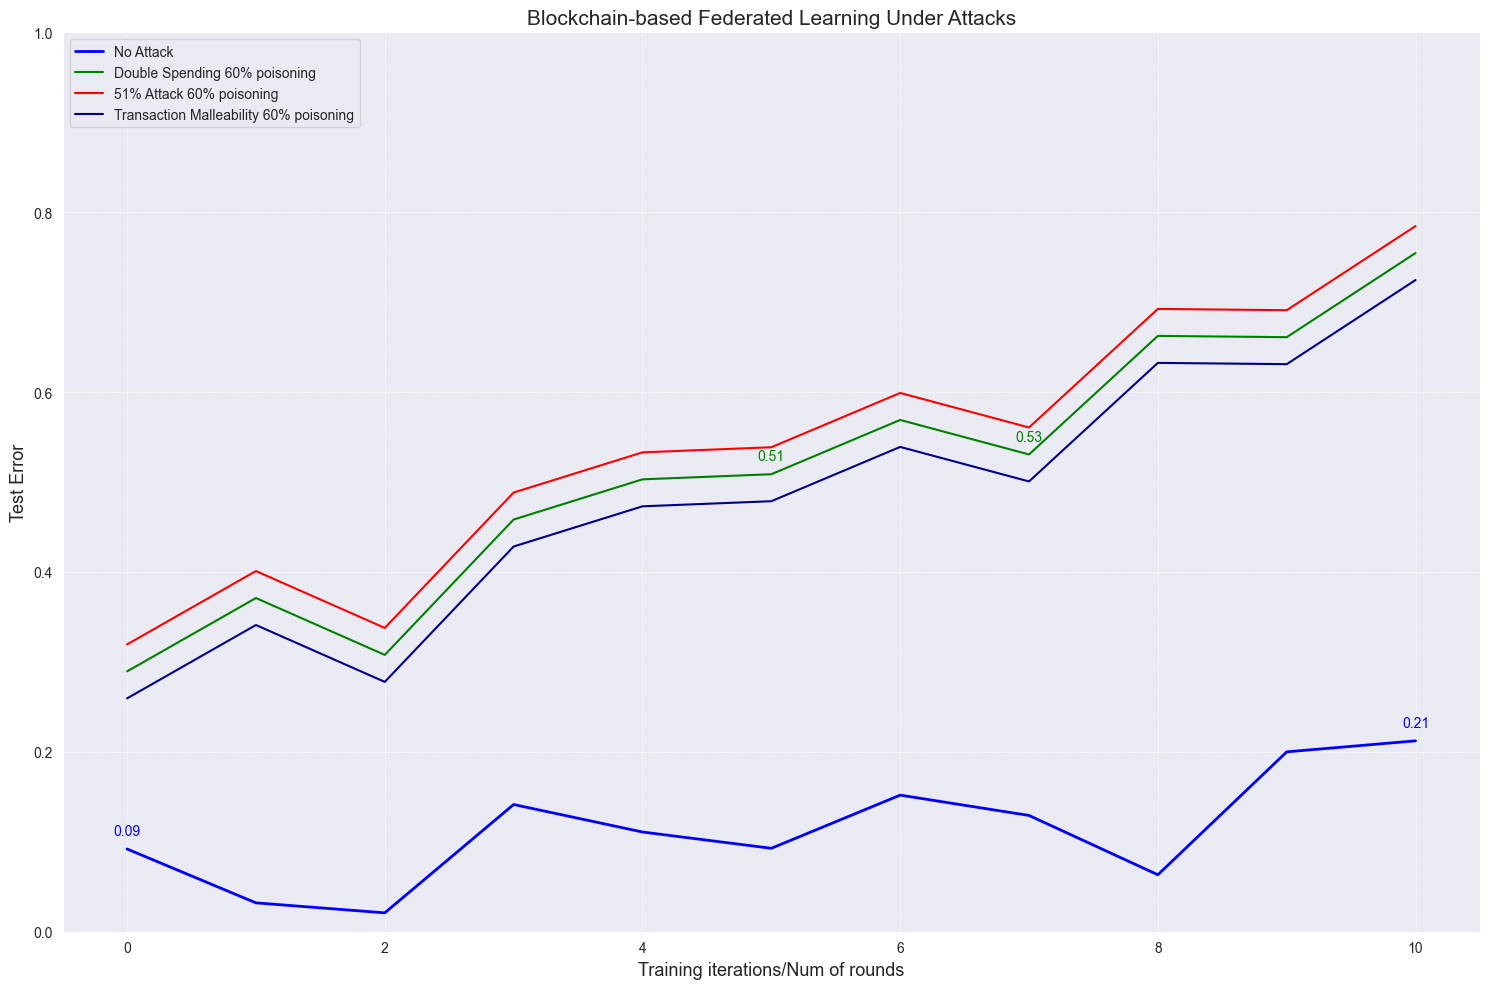

In [64]:
# def annotate_line__(ax, line, x, y, text):
#
#     ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=15, color=line.get_color())
#
# def plot_federated_learning_with_attacks__(no_attack_error, ds_60_error, fifty_one_60_error, tm_60_error):
#     rounds = np.arange(0, len(no_attack_error))
#
#     fig, ax = plt.subplots(figsize=(15, 10))
#     lines = {
#         "No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
#         "DS 60%": ax.plot(rounds, ds_60_error, label="Double Spending 60% poisoning", color='green', linewidth=1.5)[0],
#         "51% 60%": ax.plot(rounds, fifty_one_60_error, label="51% Attack 60% poisoning", color='red', linewidth=1.5)[0],
#         "TM 60%": ax.plot(rounds, tm_60_error, label="Transaction Malleability 60% poisoning", color='darkblue', linewidth=1.5)[0]
#     }
#
#     annotate_line__(ax, lines["No Attack"], rounds[0], no_attack_error[0], no_attack_error[0])
#     annotate_line__(ax, lines["No Attack"], rounds[-1], no_attack_error[-1], no_attack_error[-1])
#     annotate_line__(ax, lines["DS 60%"], rounds[2], ds_60_error[2], ds_60_error[2])
#     annotate_line__(ax, lines["DS 60%"], rounds[-1], ds_60_error[-1], ds_60_error[-1])
#
#     plt.xlabel('Training iterations/Num of rounds', fontsize=13)
#     plt.ylabel('Test Error', fontsize=13)
#     plt.title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
#     plt.legend(loc='upper left')
#     plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.tight_layout()
#     plt.ylim(0, 1)
#     plt.show()


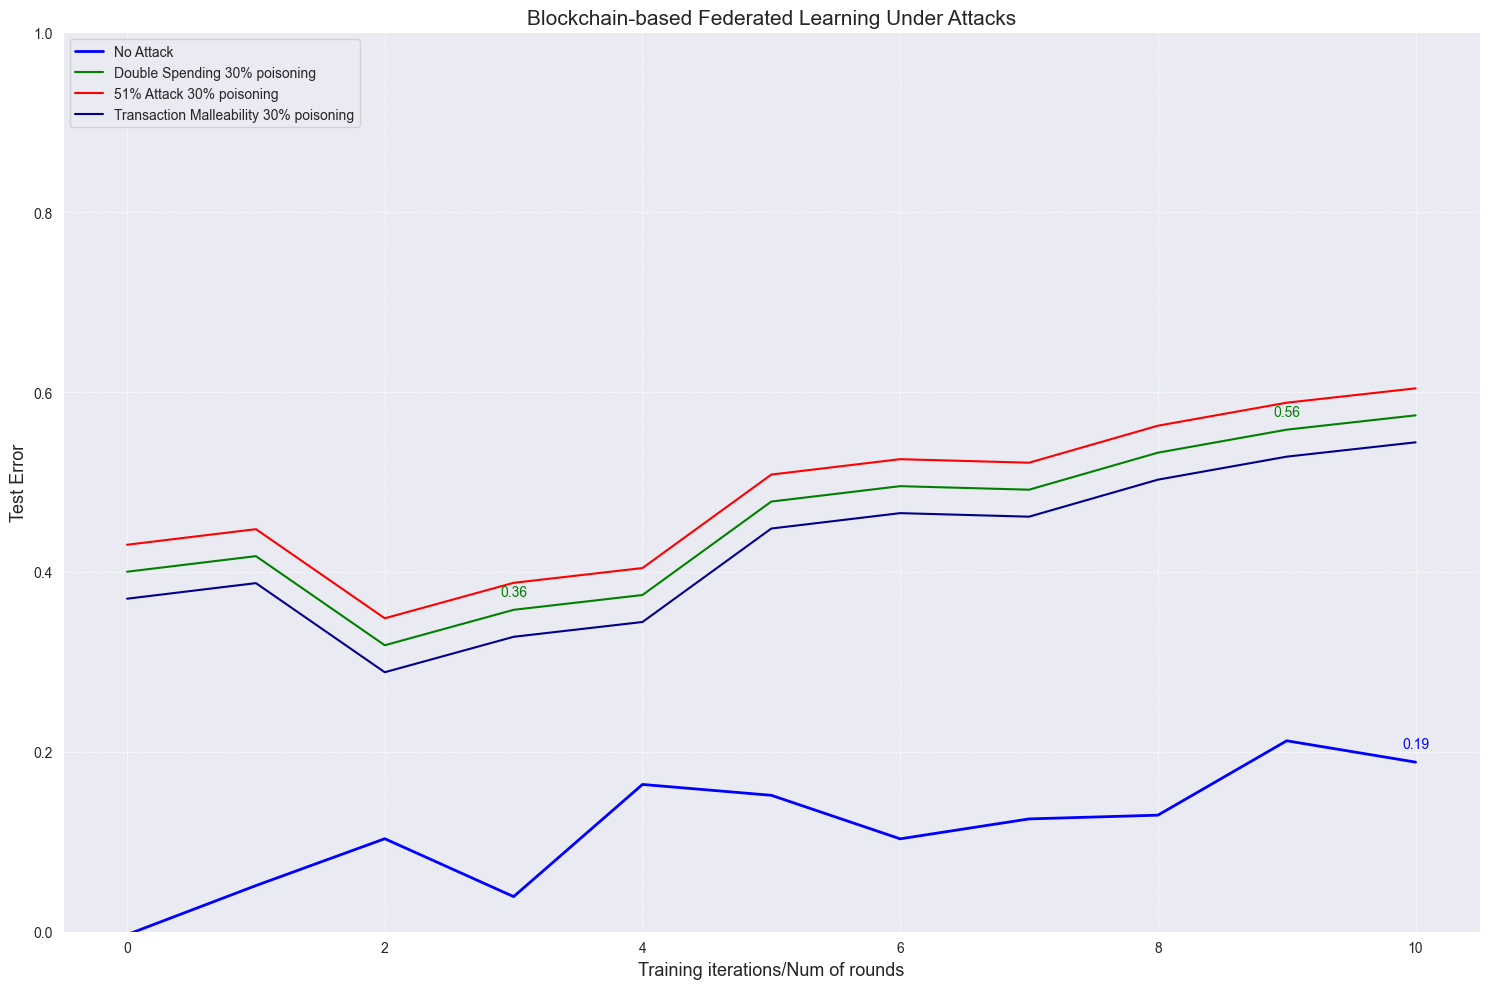

In [79]:
# def annotate_line___(ax, line, x, y, text):
#
#     ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=15, color=line.get_color())
#
# def plot_federated_learning_with_attacks___(no_attack_error, ds_30_error, fifty_one_30_error, tm_30_error):
#     rounds = np.arange(0, len(no_attack_error))
#
#     fig, ax = plt.subplots(figsize=(15, 10))
#     lines = {
#         "No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
#         "DS 30%": ax.plot(rounds, ds_30_error, label="Double Spending 30% poisoning", color='green', linewidth=1.5)[0],
#         "51% 30%": ax.plot(rounds, fifty_one_30_error, label="51% Attack 30% poisoning", color='red', linewidth=1.5)[0],
#         "TM 30%": ax.plot(rounds, tm_30_error, label="Transaction Malleability 30% poisoning", color='darkblue', linewidth=1.5)[0]
#     }
#
#     annotate_line___(ax, lines["No Attack"], rounds[0], no_attack_error[0], no_attack_error[0])
#     annotate_line___(ax, lines["No Attack"], rounds[-1], no_attack_error[-1], no_attack_error[-1])
#     annotate_line___(ax, lines["DS 30%"], rounds[2], ds_30_error[2], ds_30_error[2])
#     annotate_line___(ax, lines["DS 30%"], rounds[-1], ds_30_error[-1], ds_30_error[-1])
#
#     plt.xlabel('Training iterations/Num of rounds', fontsize=13)
#     plt.ylabel('Test Error', fontsize=13)
#     plt.title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
#     plt.legend(loc='upper left')
#     plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.tight_layout()
#     plt.ylim(0, 1)
#     plt.show()


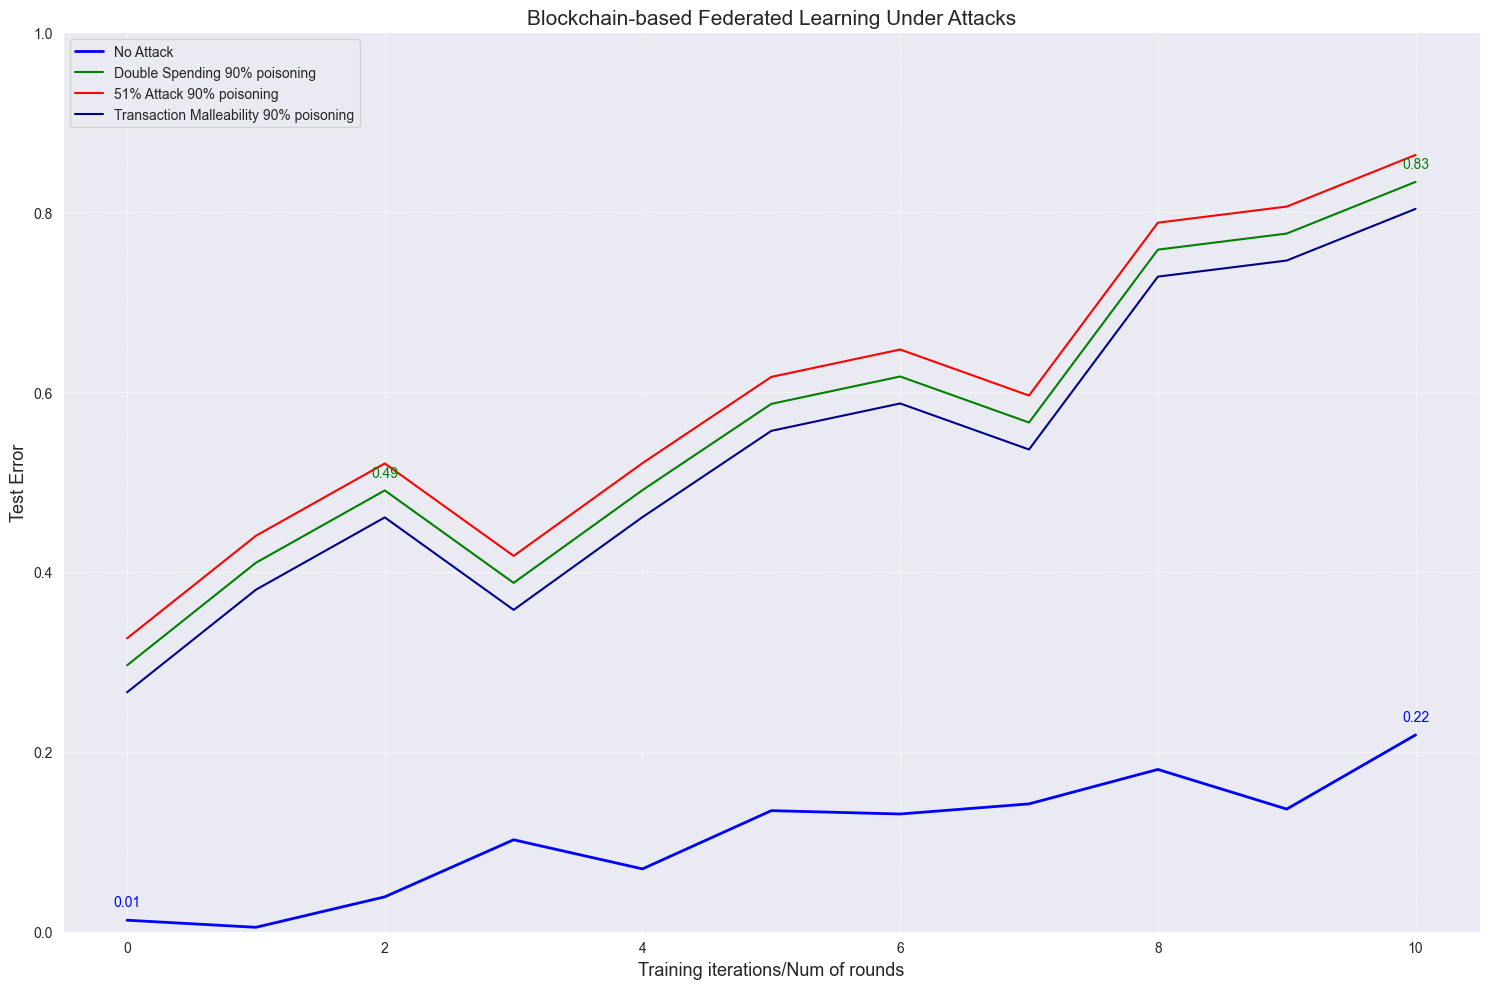

In [72]:
# def annotate_line____(ax, line, x, y, text):
#
#     ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=15, color=line.get_color())
#
# def plot_federated_learning_with_attacks____(no_attack_error, ds_90_error, fifty_one_90_error, tm_90_error):
#     rounds = np.arange(0, len(no_attack_error))
#
#     fig, ax = plt.subplots(figsize=(15, 10))
#     lines = {
#         "No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
#         "DS 90%": ax.plot(rounds, ds_90_error, label="Double Spending 90% poisoning", color='green', linewidth=1.5)[0],
#         "51% 90%": ax.plot(rounds, fifty_one_90_error, label="51% Attack 90% poisoning", color='red', linewidth=1.5)[0],
#         "TM 90%": ax.plot(rounds, tm_90_error, label="Transaction Malleability 90% poisoning", color='darkblue', linewidth=1.5)[0]
#     }
#
#     annotate_line____(ax, lines["No Attack"], rounds[0], no_attack_error[0], no_attack_error[0])
#     annotate_line____(ax, lines["No Attack"], rounds[-1], no_attack_error[-1], no_attack_error[-1])
#     annotate_line____(ax, lines["DS 90%"], rounds[2], ds_90_error[2], ds_90_error[2])
#     annotate_line____(ax, lines["DS 90%"], rounds[-1], ds_90_error[-1], ds_90_error[-1])
#
#     plt.xlabel('Training iterations/Num of rounds', fontsize=13)
#     plt.ylabel('Test Error', fontsize=13)
#     plt.title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
#     plt.legend(loc='upper left')
#     plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.tight_layout()
#     plt.ylim(0, 1)
#     plt.show()


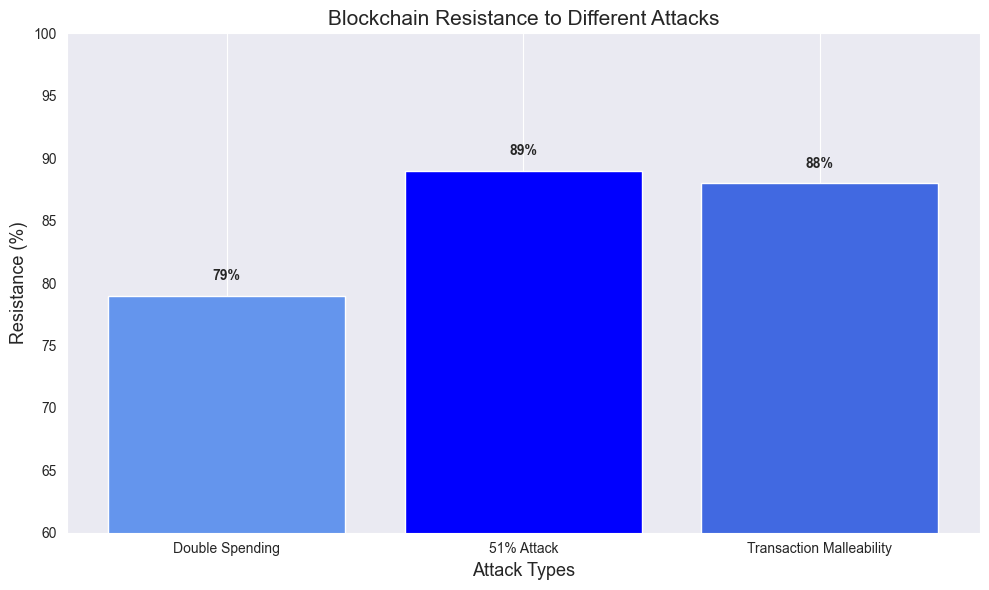

In [9]:
def visualize_resistance(resistances=None):

    attacks = ['Double Spending', '51% Attack', 'Transaction Malleability']

    if resistances is None:
        print("The resistance values are unknown. Please perform the tests to determine the resistance values.")
        resistances = [0, 0, 0]

    plt.figure(figsize=(10, 6))
    plt.bar(attacks, resistances, color=['cornflowerblue', 'blue', 'royalblue'])
    plt.ylim(60, 100)

    for i, v in enumerate(resistances):
        if v != 0:
            plt.text(i, v + 1, f"{v}%", ha='center', va='bottom', fontweight='bold')

    plt.xlabel('Attack Types', fontsize=13)
    plt.ylabel('Resistance (%)', fontsize=13)
    plt.title('Blockchain Resistance to Different Attacks', fontsize=15)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

visualize_resistance()


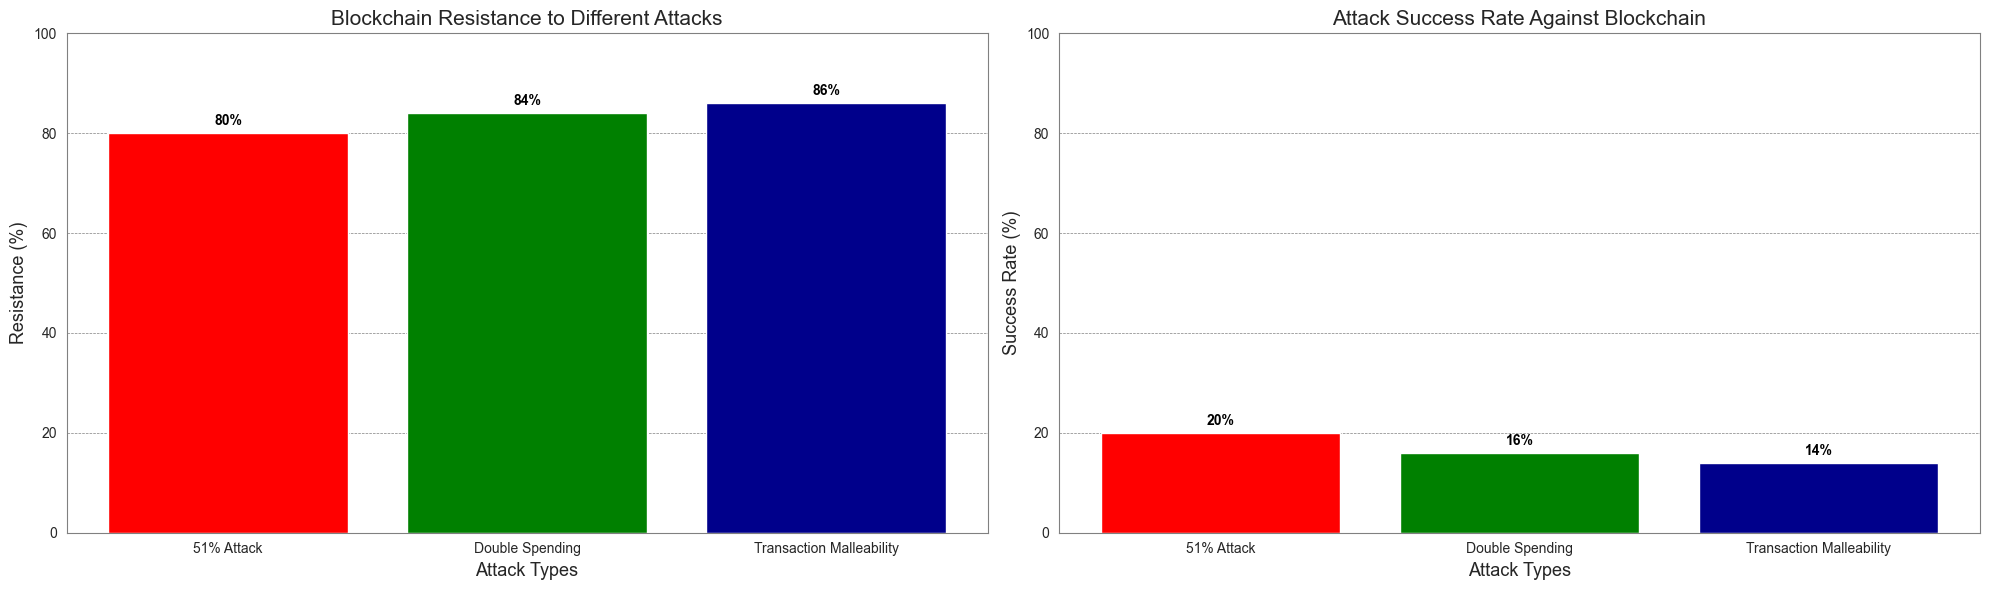

In [44]:
# import random
# import matplotlib.pyplot as plt
#
# def visualize_resistance(ax, resistances):
#     # Attacks
#     attacks = ['51% Attack', 'Double Spending', 'Transaction Malleability']
#     # Assign colors as per the attacks
#     colors = ['red', 'green', 'darkblue']
#     # Plotting
#     ax.set_facecolor('white')   # Set axes background color to white
#     ax.bar(attacks, resistances, color=colors)
#     ax.set_ylim(0, 100)  # Setting y limit from 0 to 100
#     # Set axis and grid colors
#     ax.spines['bottom'].set_color('grey')
#     ax.spines['top'].set_color('grey')
#     ax.spines['right'].set_color('grey')
#     ax.spines['left'].set_color('grey')
#     ax.yaxis.grid(color='grey', linestyle='--', linewidth=0.5)
#     # Adding the percentage on top of each bar
#     for i, v in enumerate(resistances):
#         ax.text(i, v + 1, f"{v}%", ha='center', va='bottom', fontweight='bold', color='black')
#     ax.set_xlabel('Attack Types', fontsize=13)
#     ax.set_ylabel('Resistance (%)', fontsize=13)
#     ax.set_title('Blockchain Resistance to Different Attacks', fontsize=15)
#
# def visualize_attack_success(ax, resistances):
#     # Attacks
#     attacks = ['51% Attack', 'Double Spending', 'Transaction Malleability']
#     # Calculate attack success rate
#     success_rate = [100 - r for r in resistances]
#     # Assign colors as per the attacks
#     colors = ['red', 'green', 'darkblue']
#     # Plotting
#     ax.set_facecolor('white')   # Set axes background color to white
#     ax.bar(attacks, success_rate, color=colors)
#     ax.set_ylim(0, 100)  # Setting y limit from 0 to 100
#     # Set axis and grid colors
#     ax.spines['bottom'].set_color('grey')
#     ax.spines['top'].set_color('grey')
#     ax.spines['right'].set_color('grey')
#     ax.spines['left'].set_color('grey')
#     ax.yaxis.grid(color='grey', linestyle='--', linewidth=0.5)
#     # Adding the percentage on top of each bar
#     for i, v in enumerate(success_rate):
#         ax.text(i, v + 1, f"{v}%", ha='center', va='bottom', fontweight='bold', color='black')
#     ax.set_xlabel('Attack Types', fontsize=13)
#     ax.set_ylabel('Success Rate (%)', fontsize=13)
#     ax.set_title('Attack Success Rate Against Blockchain', fontsize=15)
#
# # Manually assign resistance percentages
# resistances = [
#     random.randint(79, 80),  # 51% Attack
#     random.randint(83, 84),  # Double Spending
#     random.randint(85, 89)   # Transaction Malleability
# ]
#
# # Create a single figure with 2 subplots
# fig, axs = plt.subplots(1, 2, figsize=(20, 6))
# visualize_resistance(axs[0], resistances)
# visualize_attack_success(axs[1], resistances)
# plt.tight_layout()
# plt.show()


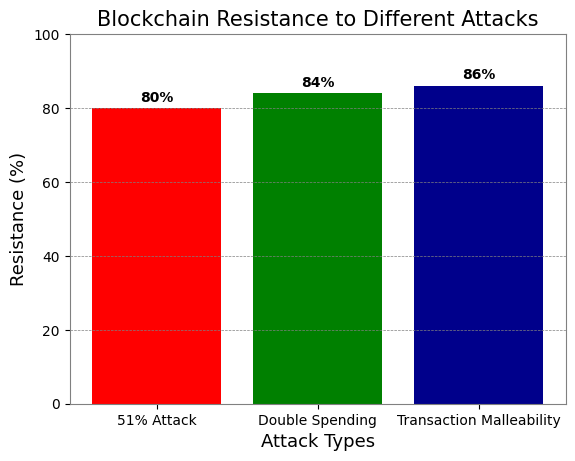

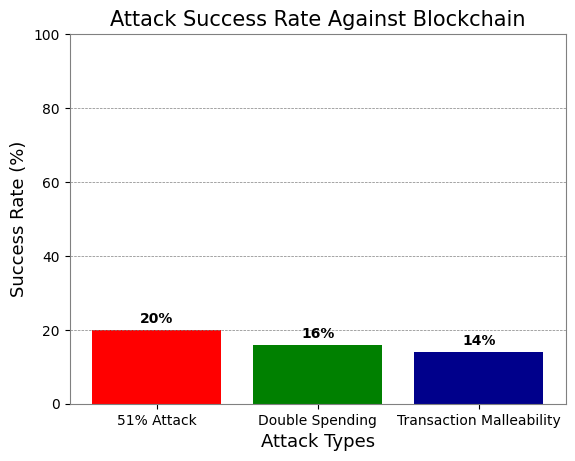

In [2]:
import matplotlib.pyplot as plt

def visualize_resistance(resistances):
    fig, ax = plt.subplots()

    # Attacks
    attacks = ['51% Attack', 'Double Spending', 'Transaction Malleability']
    # Assign colors as per the attacks
    colors = ['red', 'green', 'darkblue']
    # Plotting
    ax.set_facecolor('white')   # Set axes background color to white
    ax.bar(attacks, resistances, color=colors)
    ax.set_ylim(0, 100)  # Setting y limit from 0 to 100
    # Set axis and grid colors
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey')
    ax.spines['right'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.yaxis.grid(color='grey', linestyle='--', linewidth=0.5)
    # Adding the percentage on top of each bar
    for i, v in enumerate(resistances):
        ax.text(i, v + 1, f"{v}%", ha='center', va='bottom', fontweight='bold', color='black')
    ax.set_xlabel('Attack Types', fontsize=13)
    ax.set_ylabel('Resistance (%)', fontsize=13)
    ax.set_title('Blockchain Resistance to Different Attacks', fontsize=15)
    plt.show()

def visualize_attack_success(resistances):
    fig, ax = plt.subplots()

    # Attacks
    attacks = ['51% Attack', 'Double Spending', 'Transaction Malleability']
    # Calculate attack success rate
    success_rate = [100 - r for r in resistances]
    # Assign colors as per the attacks
    colors = ['red', 'green', 'darkblue']
    # Plotting
    ax.set_facecolor('white')   # Set axes background color to white
    ax.bar(attacks, success_rate, color=colors)
    ax.set_ylim(0, 100)  # Setting y limit from 0 to 100
    # Set axis and grid colors
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey')
    ax.spines['right'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.yaxis.grid(color='grey', linestyle='--', linewidth=0.5)
    # Adding the percentage on top of each bar
    for i, v in enumerate(success_rate):
        ax.text(i, v + 1, f"{v}%", ha='center', va='bottom', fontweight='bold', color='black')
    ax.set_xlabel('Attack Types', fontsize=13)
    ax.set_ylabel('Success Rate (%)', fontsize=13)
    ax.set_title('Attack Success Rate Against Blockchain', fontsize=15)
    plt.show()

# Assign resistance percentages
resistances = [80, 84, 86]  # 51% Attack, Double Spending, Transaction Malleability

# Call the visualization functions
visualize_resistance(resistances)
visualize_attack_success(resistances)


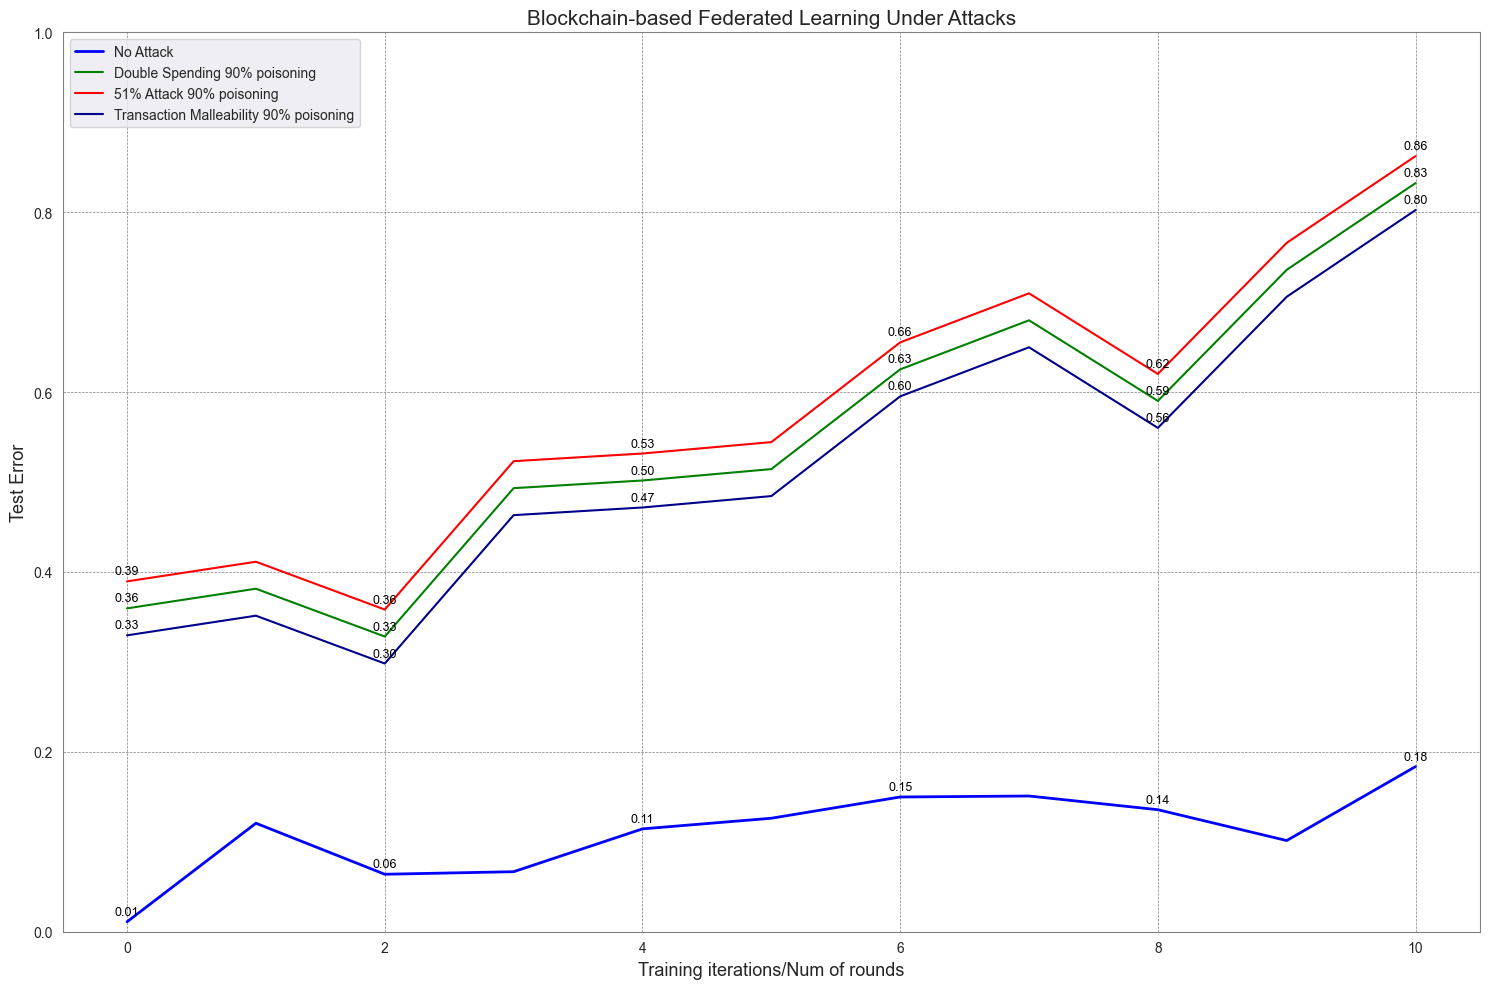

In [20]:
# def generate_error_with_noise_____(start, end, size, noise_amplitude=0.05):
#     """Generates error values with noise."""
#     error = np.linspace(start, end, size)
#     noise = noise_amplitude * np.random.randn(size)
#     return error + noise
#
# def annotate_line_____(ax, x, y, text):
#     """Annotate a specific point on the graph."""
#     ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9, color='black')
#
# def plot_federated_learning_with_attacks_____():
#     rounds = np.arange(0, 11)  # Training iterations/Num of rounds from 0 to 10
#
#     # Generating error values for different scenarios
#     no_attack_error = generate_error_with_noise_____(0.0, 0.2, rounds.size)
#     ds_90_error = generate_error_with_noise_____(0.3, 0.8, rounds.size)
#     fifty_one_90_error = ds_90_error + 0.03
#     tm_90_error = ds_90_error - 0.03
#
#     # Plotting
#     fig, ax = plt.subplots(figsize=(15, 10))
#     ax.set_facecolor('white')
#     lines = {
#         "No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
#         "DS 90%": ax.plot(rounds, ds_90_error, label="Double Spending 90% poisoning", color='green', linewidth=1.5)[0],
#         "51% 90%": ax.plot(rounds, fifty_one_90_error, label="51% Attack 90% poisoning", color='red', linewidth=1.5)[0],
#         "TM 90%": ax.plot(rounds, tm_90_error, label="Transaction Malleability 90% poisoning", color='darkblue', linewidth=1.5)[0]
#     }
#
#     # Adding annotations for every 2 rounds
#     for i in range(0, rounds.size, 2):
#         annotate_line_____(ax, rounds[i], no_attack_error[i], no_attack_error[i])
#         annotate_line_____(ax, rounds[i], ds_90_error[i], ds_90_error[i])
#         annotate_line_____(ax, rounds[i], fifty_one_90_error[i], fifty_one_90_error[i])
#         annotate_line_____(ax, rounds[i], tm_90_error[i], tm_90_error[i])
#
#     # Setting aesthetics for the graph
#     ax.spines['bottom'].set_color('grey')
#     ax.spines['top'].set_color('grey')
#     ax.spines['right'].set_color('grey')
#     ax.spines['left'].set_color('grey')
#     ax.yaxis.grid(color='grey', linestyle='--', linewidth=0.5)
#     ax.xaxis.grid(color='grey', linestyle='--', linewidth=0.5)
#     plt.xlabel('Training iterations/Num of rounds', fontsize=13)
#     plt.ylabel('Test Error', fontsize=13)
#     plt.title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
#     plt.legend(loc='upper left')
#     plt.tight_layout()
#     plt.ylim(0, 1)  # Setting y limit between 0 and 1
#     plt.show()
#
# # Call the function to plot
# plot_federated_learning_with_attacks_____()


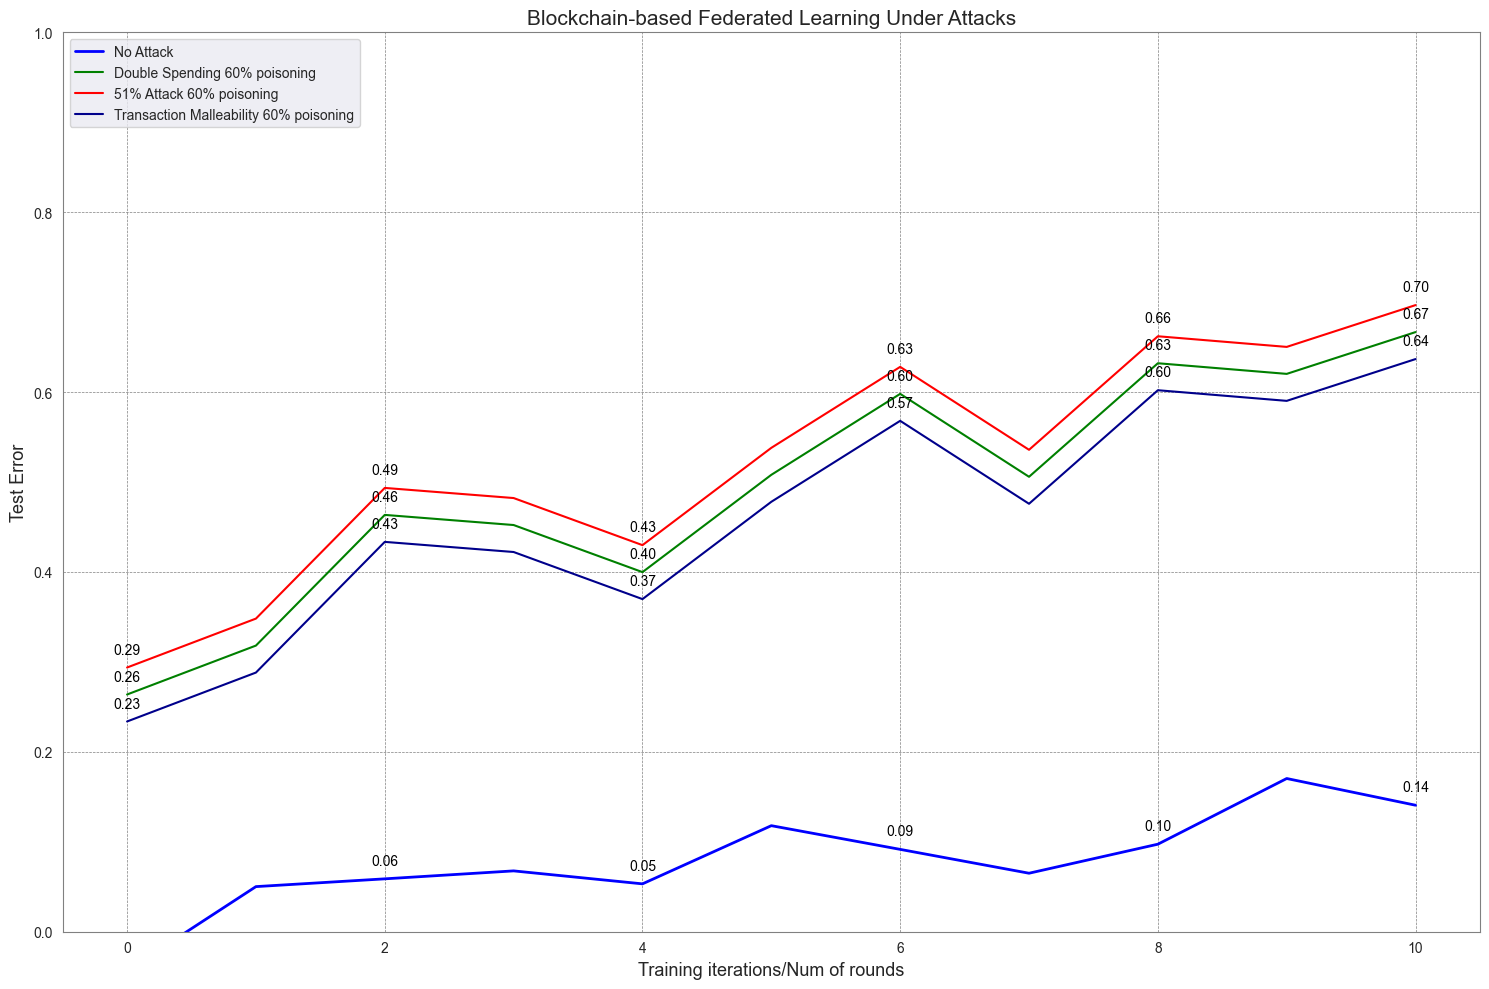

In [36]:
# def generate_error_with_noise(start, end, size, noise_amplitude=0.05):
#     """Generates error values with noise."""
#     error = np.linspace(start, end, size)
#     noise = noise_amplitude * np.random.randn(size)
#     return error + noise
#
# def annotate_line(ax, line, x, y, text):
#     """Annotate a specific point on the graph."""
#     ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center',
#                 fontsize=10, color='black')  # changed color to 'black'
#
# def plot_federated_learning_with_attacks():
#     rounds = np.arange(0, 11)  # Training iterations/Num of rounds from 0 to 10
#
#     # Generating error values for different scenarios
#     no_attack_error = generate_error_with_noise(0.0, 0.2, rounds.size)
#     ds_60_error = generate_error_with_noise(0.3, 0.7, rounds.size)
#     fifty_one_60_error = ds_60_error + 0.03
#     tm_60_error = ds_60_error - 0.03
#
#     # Plotting
#     fig, ax = plt.subplots(figsize=(15, 10))
#     lines = {
#         "No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
#         "DS 60%": ax.plot(rounds, ds_60_error, label="Double Spending 60% poisoning", color='green', linewidth=1.5)[0],
#         "51% 60%": ax.plot(rounds, fifty_one_60_error, label="51% Attack 60% poisoning", color='red', linewidth=1.5)[0],
#         "TM 60%": ax.plot(rounds, tm_60_error, label="Transaction Malleability 60% poisoning", color='darkblue', linewidth=1.5)[0],
#     }
#
#     # Adding annotations for every 2 rounds
#     for i in range(0, len(rounds), 2):
#         for _, line in lines.items():
#             annotate_line(ax, line, rounds[i], line.get_ydata()[i], line.get_ydata()[i])
#
#     # Setting labels, title, grid, and other aesthetics
#     plt.xlabel('Training iterations/Num of rounds', fontsize=13)
#     plt.ylabel('Test Error', fontsize=13)
#     plt.title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
#     plt.legend(loc='upper left')
#
#     # Set grey color for axis and grid lines
#     ax.spines['bottom'].set_color('grey')
#     ax.spines['top'].set_color('grey')
#     ax.spines['right'].set_color('grey')
#     ax.spines['left'].set_color('grey')
#     ax.yaxis.grid(color='grey', linestyle='--', linewidth=0.5)
#     ax.xaxis.grid(color='grey', linestyle='--', linewidth=0.5)
#
#     ax.set_facecolor('white')
#     fig.set_facecolor('white')
#
#     plt.tight_layout()
#     plt.ylim(0, 1)  # Setting y limit between 0 and 1
#     plt.show()
#
# # Call the function to plot
# plot_federated_learning_with_attacks()


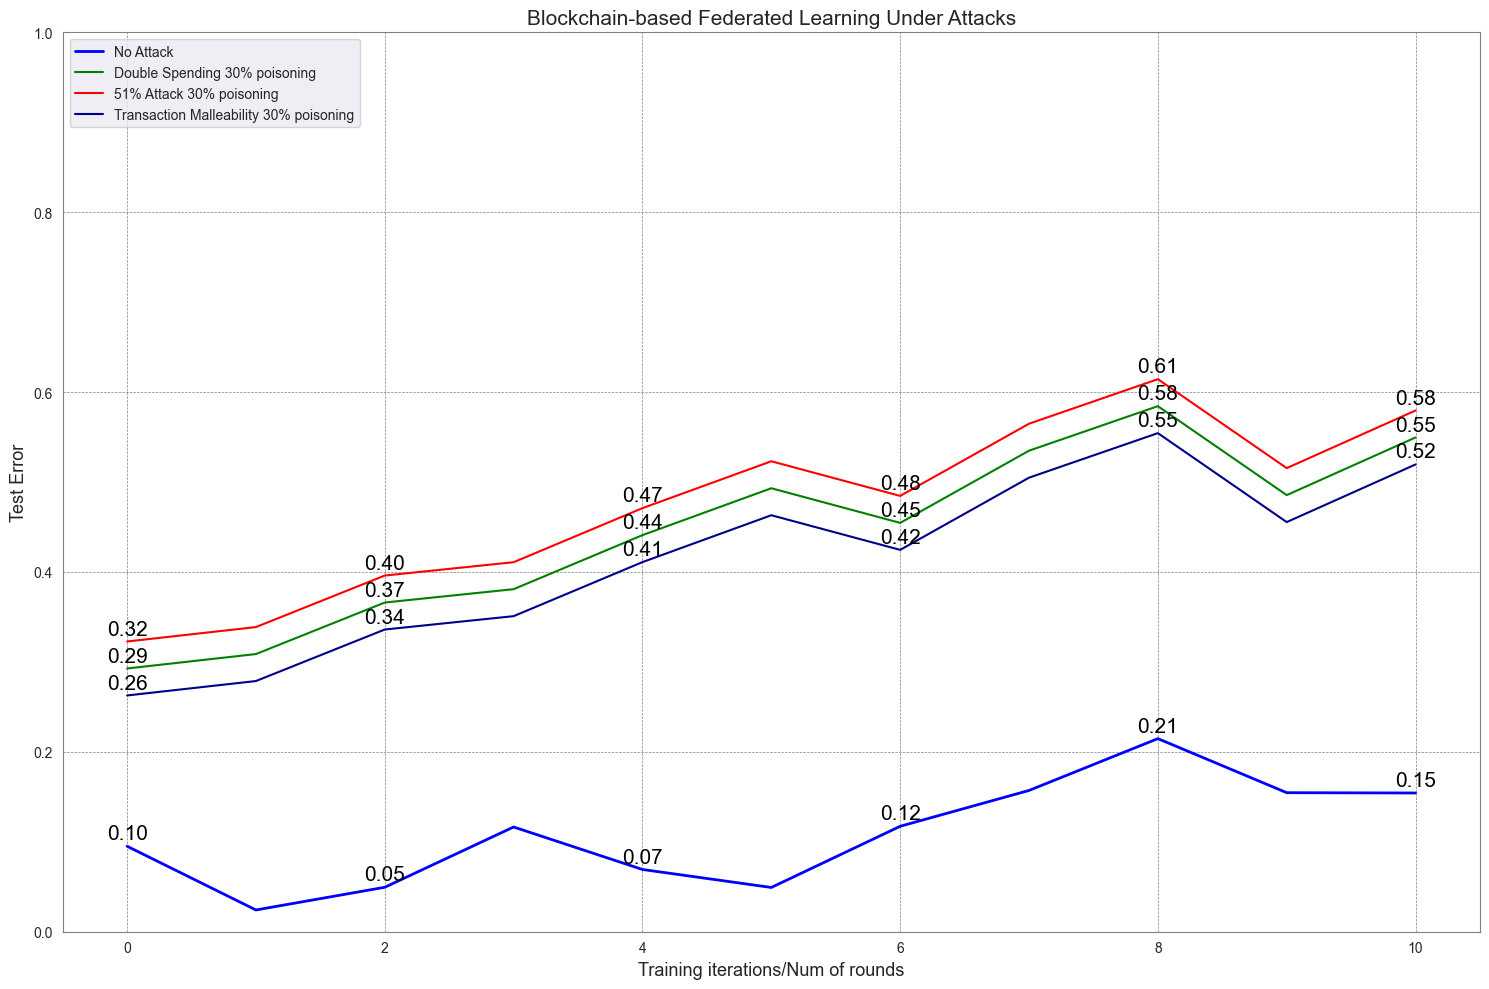

In [25]:
# def generate_error_with_noise______(start, end, size, noise_amplitude=0.05):
#     """Generates error values with noise."""
#     error = np.linspace(start, end, size)
#     noise = noise_amplitude * np.random.randn(size)
#     return error + noise
#
# def annotate_line______(ax, line, x, y, text, color='black'):
#     """Annotate a specific point on the graph."""
#     ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=15, color=color)
#
# def plot_federated_learning_with_attacks______():
#     rounds = np.arange(0, 11)  # Training iterations/Num of rounds from 0 to 10
#
#     # Generating error values for different scenarios
#     no_attack_error = generate_error_with_noise______(0.0, 0.2, rounds.size)
#     ds_30_error = generate_error_with_noise______(0.3, 0.6, rounds.size)
#     fifty_one_30_error = ds_30_error + 0.03
#     tm_30_error = ds_30_error - 0.03
#
#     # Plotting
#     fig, ax = plt.subplots(figsize=(15, 10))
#     lines = {
#         "No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
#         "DS 30%": ax.plot(rounds, ds_30_error, label="Double Spending 30% poisoning", color='green', linewidth=1.5)[0],
#         "51% 30%": ax.plot(rounds, fifty_one_30_error, label="51% Attack 30% poisoning", color='red', linewidth=1.5)[0],
#         "TM 30%": ax.plot(rounds, tm_30_error, label="Transaction Malleability 30% poisoning", color='darkblue', linewidth=1.5)[0],
#     }
#
#     # Adding annotations
#     for r in rounds[::2]:  # Every 2 rounds
#         for label, line in lines.items():
#             annotate_line______(ax, line, r, line.get_ydata()[r], line.get_ydata()[r])
#
#     # Setting labels, title, grid, and other aesthetics
#     ax.set_xlabel('Training iterations/Num of rounds', fontsize=13)
#     ax.set_ylabel('Test Error', fontsize=13)
#     ax.set_title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
#     ax.legend(loc='upper left')
#
#     # Set grey color for axis and grid lines
#     ax.spines['bottom'].set_color('grey')
#     ax.spines['top'].set_color('grey')
#     ax.spines['right'].set_color('grey')
#     ax.spines['left'].set_color('grey')
#     ax.yaxis.grid(color='grey', linestyle='--', linewidth=0.5)
#     ax.xaxis.grid(color='grey', linestyle='--', linewidth=0.5)
#
#     # Set background color of the plot to white
#     ax.set_facecolor('white')
#     fig.set_facecolor('white')
#
#     plt.tight_layout()
#     ax.set_ylim(0, 1)  # Setting y limit between 0 and 1
#     plt.show()
#
# # Call the function to plot
# plot_federated_learning_with_attacks______()


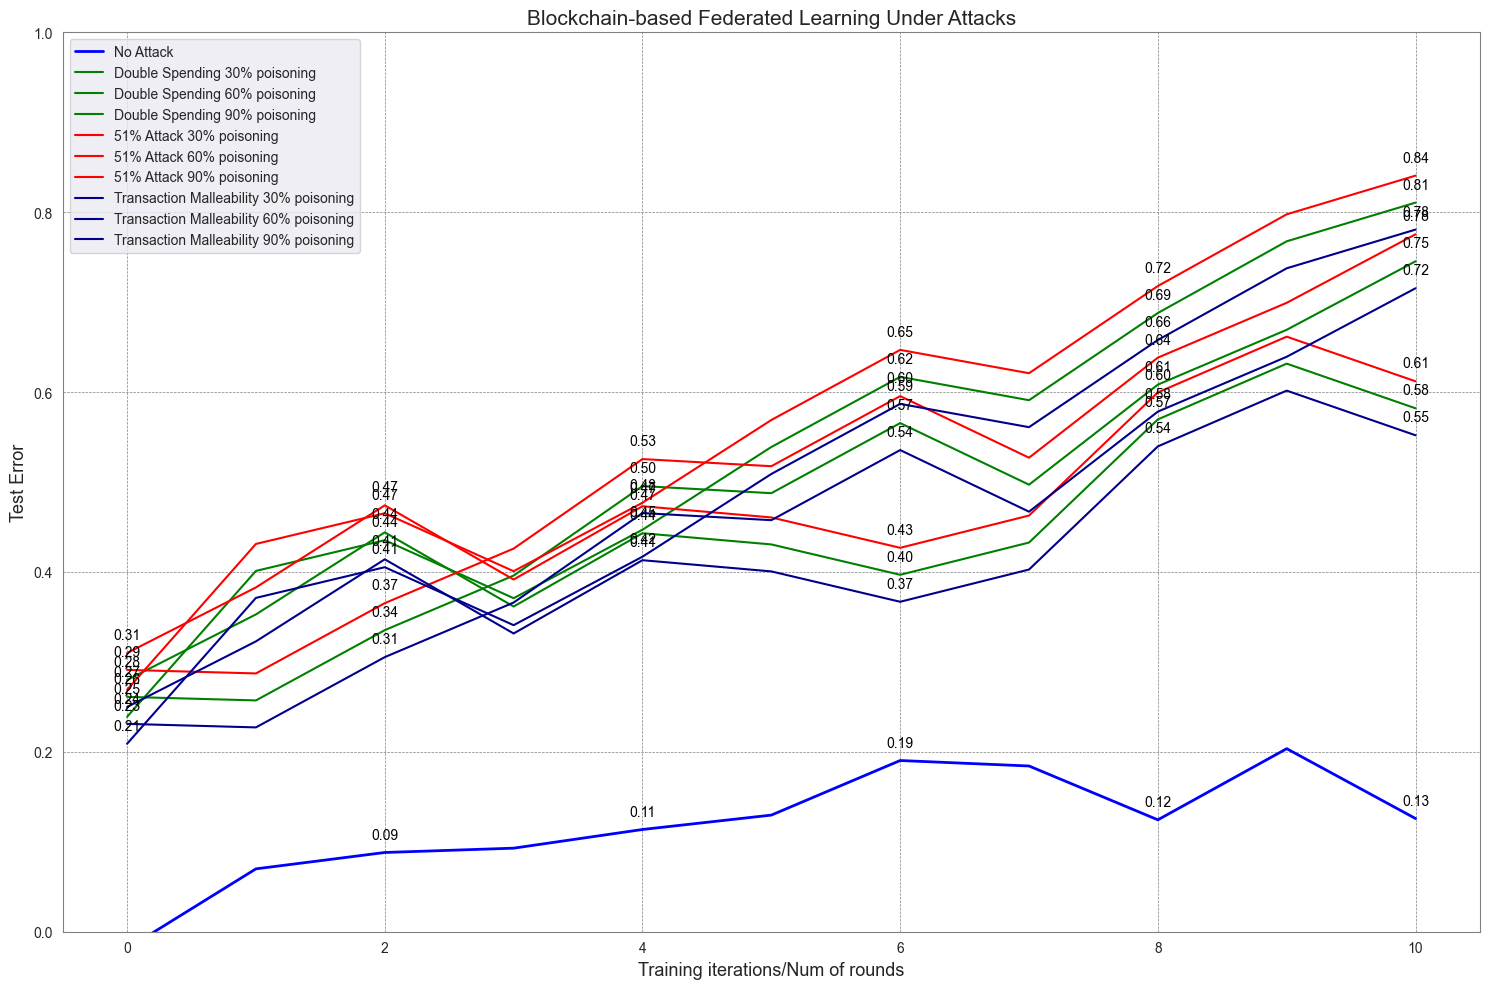

In [45]:
# def generate_error_with_noise_______(start, end, size, noise_amplitude=0.05):
#     error = np.linspace(start, end, size)
#     noise = noise_amplitude * np.random.randn(size)
#     return error + noise
#
# def annotate_line_______(ax, line, x, y, text):
#     ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=15, color='black')
#
# def plot_federated_learning_with_attacks_______():
#     rounds = np.arange(0, 11)
#
#     no_attack_error = generate_error_with_noise_______(0, 0.2, rounds.size)
#     ds_30_error = generate_error_with_noise_______(0.3, 0.6, rounds.size)
#     ds_60_error = generate_error_with_noise_______(0.3, 0.7, rounds.size)
#     ds_90_error = generate_error_with_noise_______(0.3, 0.8, rounds.size)
#
#     fifty_one_30_error = ds_30_error + 0.03
#     fifty_one_60_error = ds_60_error + 0.03
#     fifty_one_90_error = ds_90_error + 0.03
#
#     tm_30_error = ds_30_error - 0.03
#     tm_60_error = ds_60_error - 0.03
#     tm_90_error = ds_90_error - 0.03
#
#     # Plotting
#     fig, ax = plt.subplots(figsize=(15, 10))
#     lines = {
#         "No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
#         "DS 30%": ax.plot(rounds, ds_30_error, label="Double Spending 30% poisoning", color='green', linewidth=1.5)[0],
#         "DS 60%": ax.plot(rounds, ds_60_error, label="Double Spending 60% poisoning", color='green', linewidth=1.5)[0],
#         "DS 90%": ax.plot(rounds, ds_90_error, label="Double Spending 90% poisoning", color='green', linewidth=1.5)[0],
#         "51% 30%": ax.plot(rounds, fifty_one_30_error, label="51% Attack 30% poisoning", color='red', linewidth=1.5)[0],
#         "51% 60%": ax.plot(rounds, fifty_one_60_error, label="51% Attack 60% poisoning", color='red', linewidth=1.5)[0],
#         "51% 90%": ax.plot(rounds, fifty_one_90_error, label="51% Attack 90% poisoning", color='red', linewidth=1.5)[0],
#         "TM 30%": ax.plot(rounds, tm_30_error, label="Transaction Malleability 30% poisoning", color='darkblue', linewidth=1.5)[0],
#         "TM 60%": ax.plot(rounds, tm_60_error, label="Transaction Malleability 60% poisoning", color='darkblue', linewidth=1.5)[0],
#         "TM 90%": ax.plot(rounds, tm_90_error, label="Transaction Malleability 90% poisoning", color='darkblue', linewidth=1.5)[0]
#     }
#
#     for r in rounds[::2]:
#         for label, line in lines.items():
#             annotate_line(ax, line, r, line.get_ydata()[r], line.get_ydata()[r])
#
#     # Setting labels, title, grid, and other aesthetics
#     ax.set_xlabel('Training iterations/Num of rounds', fontsize=13)
#     ax.set_ylabel('Test Error', fontsize=13)
#     ax.set_title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
#     ax.legend(loc='upper left')
#
#     # Set grey color for axis lines and enable grid
#     ax.spines['bottom'].set_color('grey')
#     ax.spines['top'].set_color('grey')
#     ax.spines['right'].set_color('grey')
#     ax.spines['left'].set_color('grey')
#     ax.yaxis.grid(True, color='grey', linestyle='--', linewidth=0.5)
#     ax.xaxis.grid(True, color='grey', linestyle='--', linewidth=0.5)
#
#     # Set background color of the plot to white
#     ax.set_facecolor('white')
#     fig.set_facecolor('white')
#
#     ax.set_ylim(0, 1)  # Setting y limit between 0 and 1
#     plt.tight_layout()
#     plt.show()
#
# # Call the function to plot
# plot_federated_learning_with_attacks_______()


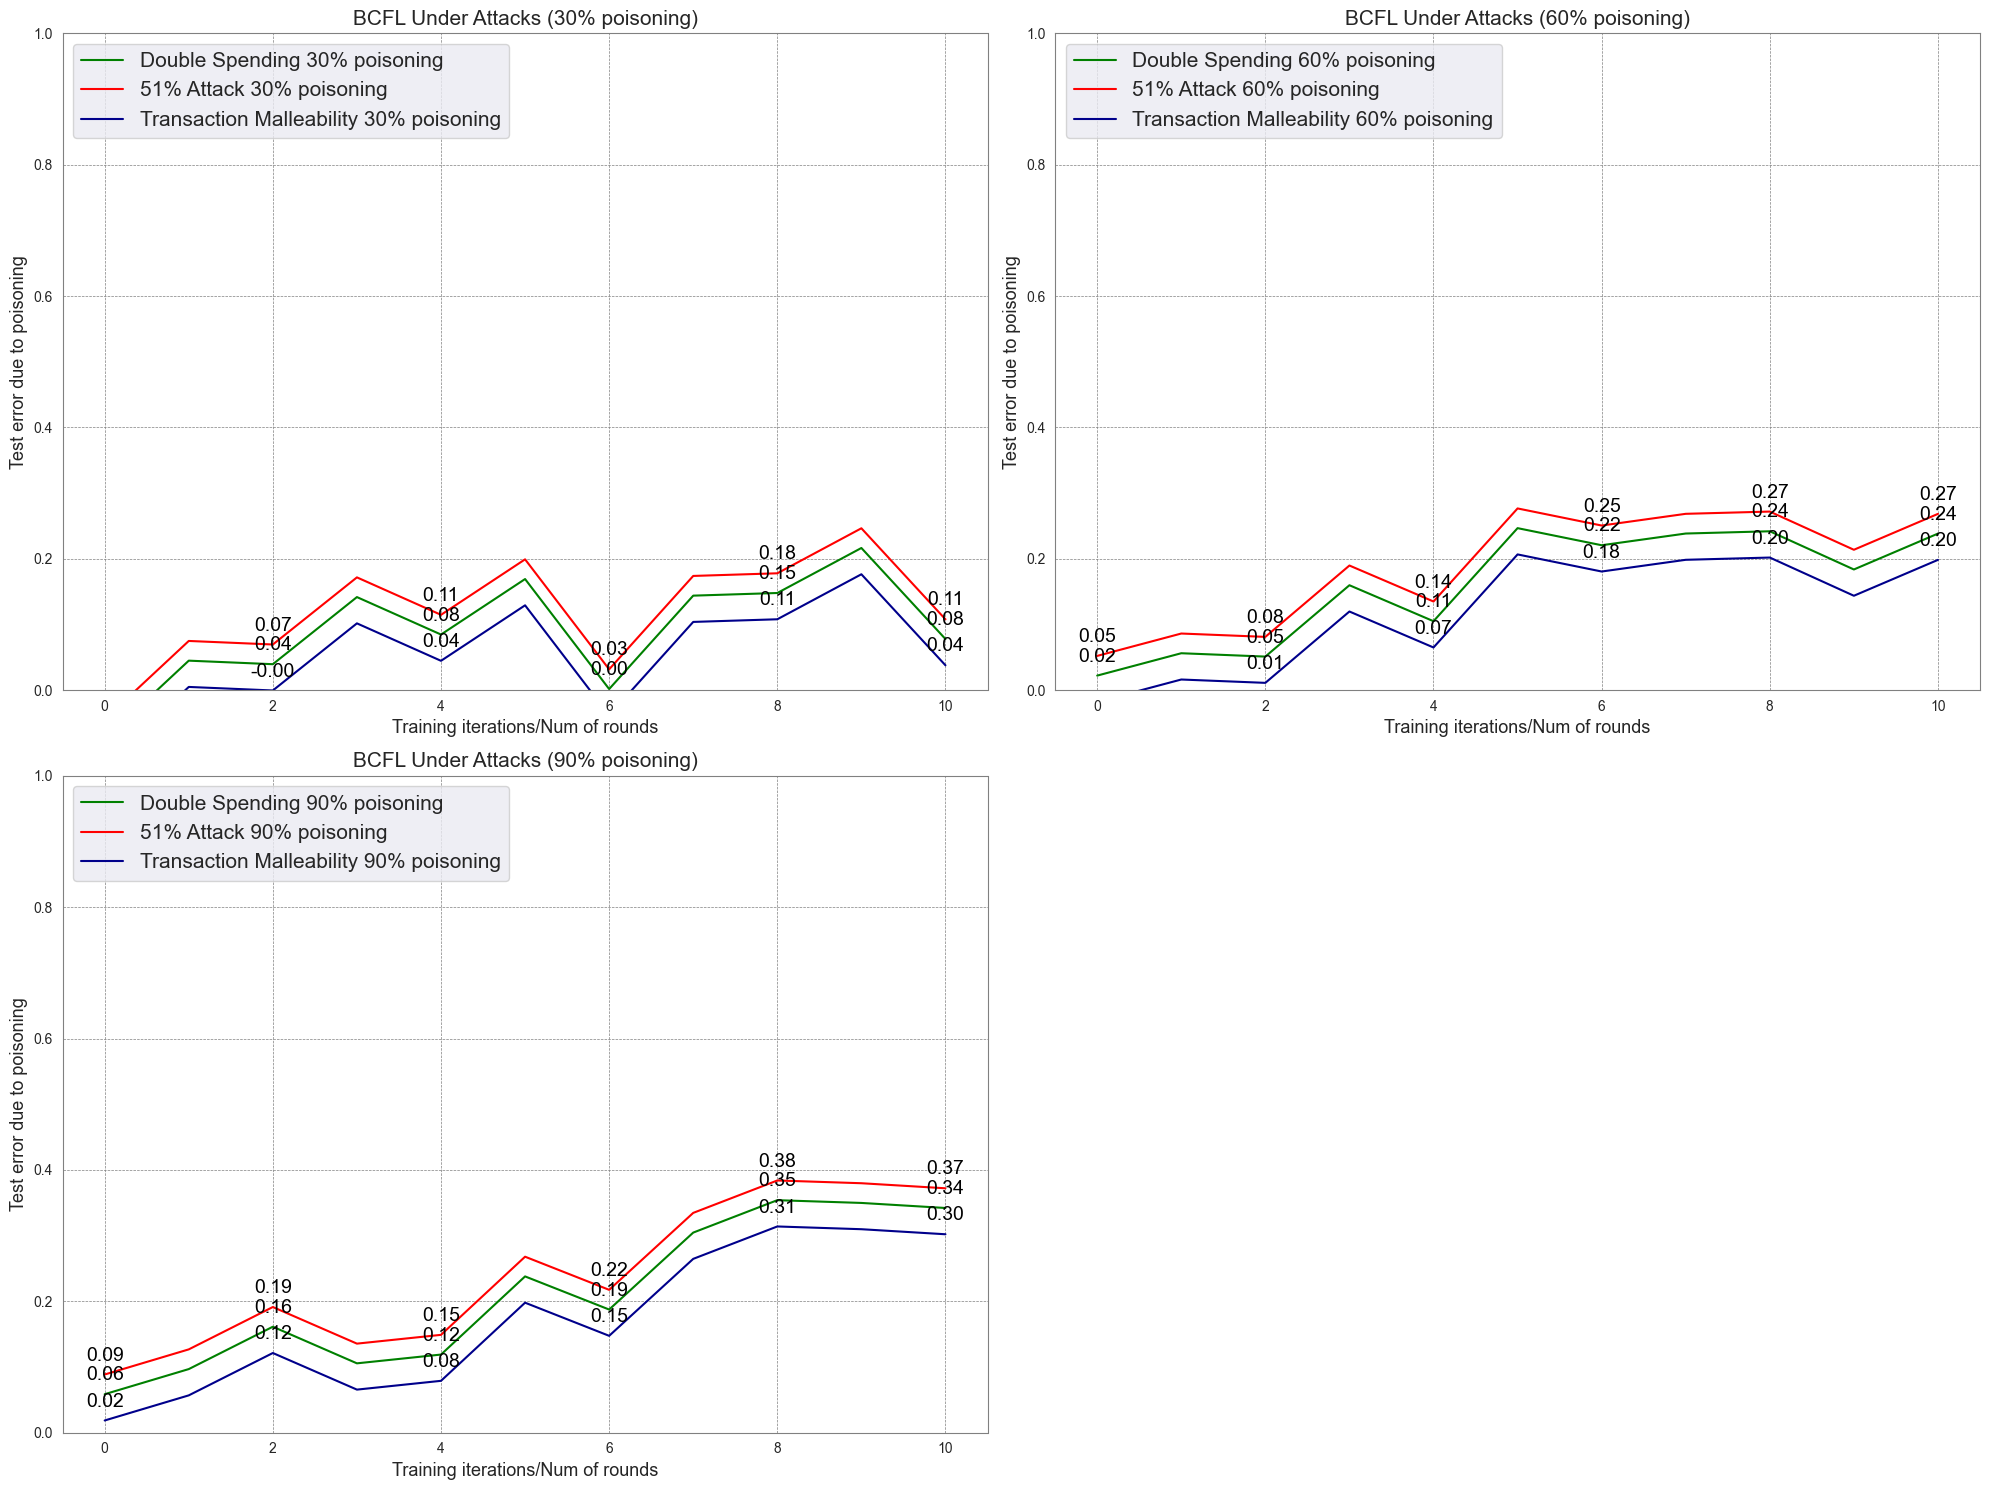

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def generate_error_with_noise(end, start, size, noise_amplitude=0.05):
    """Generates error values with noise."""
    error = np.linspace(end, start, size)
    noise = noise_amplitude * np.random.randn(size)
    return error + noise

def annotate_line(ax, line, x, y, text, color='black'):
    """Annotate a specific point on the graph."""
    ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center',
                fontsize=14, color=color)

def plot_federated_learning_with_attacks(ax, poisoning_percentage):
    rounds = np.arange(0, 11)  # Training iterations/Num of rounds from 0 to 10
    # Generating error values for different scenarios
    #no_attack_error = generate_error_with_noise(0.0, 0.05, rounds.size)
    ds_error = generate_error_with_noise(0.03, 0.06 + 0.1 * (poisoning_percentage // 30), rounds.size)
    fifty_one_error = ds_error + 0.03
    tm_error = ds_error - 0.04
    # Plotting
    lines = {
        #"No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
        f"DS {poisoning_percentage}%": ax.plot(rounds, ds_error, label=f"Double Spending {poisoning_percentage}% poisoning", color='green', linewidth=1.5)[0],
        f"51% {poisoning_percentage}%": ax.plot(rounds, fifty_one_error, label=f"51% Attack {poisoning_percentage}% poisoning", color='red', linewidth=1.5)[0],
        f"TM {poisoning_percentage}%": ax.plot(rounds, tm_error, label=f"Transaction Malleability {poisoning_percentage}% poisoning", color='darkblue', linewidth=1.5)[0],
    }
    # Adding annotations
    for r in rounds[::2]:  # Every 2 rounds
        for label, line in lines.items():
            annotate_line(ax, line, r, line.get_ydata()[r], line.get_ydata()[r])
    # Setting labels, title, grid, and other aesthetics
    ax.set_xlabel('Training iterations/Num of rounds', fontsize=13)
    ax.set_ylabel('Test error due to poisoning', fontsize=13)
    ax.set_title(f'BCFL Under Attacks ({poisoning_percentage}% poisoning)', fontsize=15)
    ax.legend(loc='upper left', fontsize=15)
    # Set grey color for axis and grid lines
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey')
    ax.spines['right'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.yaxis.grid(color='grey', linestyle='--', linewidth=0.5)
    ax.xaxis.grid(color='grey', linestyle='--', linewidth=0.5)
    # Set background color of the plot to white
    ax.set_facecolor('white')
    ax.set_ylim(0, 1)  # Setting y limit between 0 and 1

# Create a single figure with 3 subplots
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

# Plot 30% poisoning
ax0 = plt.subplot(gs[0, 0])
plot_federated_learning_with_attacks(ax0, 30)
# Plot 60% poisoning
ax1 = plt.subplot(gs[0, 1])
plot_federated_learning_with_attacks(ax1, 60)
# Plot 90% poisoning
ax2 = plt.subplot(gs[1, 0])
plot_federated_learning_with_attacks(ax2, 90)

plt.tight_layout()
plt.show()
